In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn import model_selection
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import lightgbm as lgbm
from sklearn.ensemble import RandomForestClassifier
import time
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
xgb.__version__

'1.0.2'

In [ ]:
pd.__version__

'0.23.1'

In [ ]:
%%time
PATH_TO_DATA = '/data/isbagaut/'
DATA_NAME = 'train_final_large.csv' 
data = pd.read_csv(os.path.join(PATH_TO_DATA, DATA_NAME))

CPU times: user 51.3 s, sys: 5.28 s, total: 56.5 s
Wall time: 56.5 s


In [ ]:
data.head()

,Unnamed: 0,accessory_hits_flg,actual_balance,all_mega_sms_cnt,amount_30_ratio,amount_ratio,antivirus_flg,appm_max12,appm_max4,appm_s12,...,voice_wrkd_night_rate,warm_reception_flg,webmail_top8_flg,yandexmusic_streaming_flg,zam_gud_flg,zg_cr_m3,zg_mod_flg,zg_ot2_1_flg_m3,zg_ot2_3_flg_m3,group_id
0,0,0.0,1037.49,20.0,0.0,1.004224,0.0,83.798890,28.818443,2.719855,...,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0
1,1,0.0,1037.49,20.0,0.0,1.004224,0.0,83.798890,28.818443,2.719855,...,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0
2,2,0.0,1437.24,54.0,0.0,1.000000,0.0,9.301661,2.751594,0.870738,...,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,1
3,3,0.0,1437.24,54.0,0.0,1.000000,0.0,9.301661,2.751594,0.870738,...,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,1
4,4,0.0,-114.13,13.0,0.0,0.147630,0.0,3900.015600,0.067820,1.545098,...,0.0,NaN,0.0,0.0,0.0,NaN,1.0,NaN,NaN,2


Список фичей из продового скрипта скоринга

In [ ]:
prod_feat = ['target','group_id','accessory_hits_flg', 'actual_balance', 'all_mega_sms_cnt', 'amount_30_ratio', 'amount_ratio', 'appm_max12', 'appm_max4', 'appm_s12', 'appm_s8', 'area_homenet_cnt_s12', 'area_homenet_cnt_s8', 'arpu_diff', 'audiobooks_mod_flg', 'balance_on_fb_a8', 'break_balance', 'brnc_brnc_id', 'call_dur_in_fav_max_ratep', 'call_dur_out_fav_max_ratep', 'call_dur_out_fav_max_ratep4', 'call_in_cnt_fav_max_ratep4', 'call_out_cnt_fav_max_rate4', 'call_out_cnt_fav_max_rate_1', 'call_out_cnt_fav_max_ratep4', 'card_mastercard_flg', 'cash_flg', 'cc_out_dur_s1', 'cc_out_dur_s4', 'cell_homenet_cnt', 'cell_homenet_cnt_s4', 'chrg_homenet_sms_out_s4', 'chrg_mk_brt_s4', 'chrg_mk_brt_s8', 'chrg_voice_out_s12', 'chrg_voice_out_s4', 'churn_rate_trpl', 'client_age', 'clust_hid', 'clust_subs', 'cnt_of_fb_s12', 'cnt_packs', 'conv_m2', 'conv_m3', 'cr_m1', 'cr_m2', 'cr_m3', 'cvm_books_flg', 'data_wknd_night_rate4', 'data_wrkd_rate4', 'date_auto_mf_on', 'date_sign_pku_on', 'days_in_fb_s12', 'dou_23g_s4', 'dou_m1', 'dou_m2', 'dou_max12', 'dou_max8', 'dou_min12', 'dou_min4', 'dou_min8', 'dou_ratio_full_period', 'dou_s12', 'dpi_gaming_s4', 'dpi_messenger_wa_s4', 'dpi_streaming_audio_s1', 'dpi_streaming_audio_s4', 'dpi_webmail_gmail_s4', 'dvtp_dvtp_id', 'enter_hits_flg', 'filial_id', 'hate_m2', 'hate_m3', 'hid', 'hist_hate_1m', 'hist_hate_2m', 'id_product', 'inquiry_action_avg_time', 'is_available', 'is_woman_flg', 'last_4g_date', 'last_charges_date', 'last_data_date', 'last_mf_rm_date', 'last_mms_out_date', 'last_paym_date', 'last_rm_data_date', 'last_sms_out_date', 'lifetime', 'lk_cnt_lift', 'ltv', 'mapping_accessory_hits_flg', 'mapping_audiobooks_mod_flg', 'mapping_autopay_mod_flg', 'mapping_b2c_flg', 'mapping_books_flg', 'mapping_books_hits_flg', 'mapping_cash_hits_flg', 'mapping_clothes_hits_flg', 'mapping_cloud_services_top8_flg', 'mapping_cvm_audiobooks_flg', 'mapping_cvm_books_flg', 'mapping_data_traffic_ptl70_flg', 'mapping_dou_1gb_flg', 'mapping_dou_flg', 'mapping_eda_hits_flg', 'mapping_electronics_hits_flg', 'mapping_enter_hits_flg', 'mapping_file_dnld_share_top8_flg', 'mapping_home_hits_flg', 'mapping_interest_auto_flg', 'mapping_interest_beauty_flg', 'mapping_interest_clothes_flg', 'mapping_interest_edu_flg', 'mapping_interest_entertain_flg', 'mapping_interest_kids_flg', 'mapping_is_male_flg', 'mapping_is_top_user_flg', 'mapping_kino_hits_flg', 'mapping_kitai_hits_flg', 'mapping_mf_music_v2_flg', 'mapping_mftv_film_flg', 'mapping_mftv_kids_flg', 'mapping_mftv_moretv_flg', 'mapping_mob_com_flg', 'mapping_mou_flg', 'mapping_mou_in_more_out_flg', 'mapping_music_flg', 'mapping_music_hits_flg', 'mapping_onb_antivir_flg', 'mapping_onb_audiobooks_flg', 'mapping_onb_bcard_flg', 'mapping_onb_books_flg', 'mapping_onb_cashback_flg', 'mapping_onb_dress_flg', 'mapping_onb_edu_online_flg', 'mapping_onb_edu_tech_flg', 'mapping_onb_fashion_flg', 'mapping_onb_fitness_flg', 'mapping_onb_flower_flg', 'mapping_onb_food_delivery_flg', 'mapping_onb_home_flg', 'mapping_onb_insurance_flg', 'mapping_onb_int_shop_flg', 'mapping_onb_med_online_flg', 'mapping_onb_music_flg', 'mapping_onb_payments_flg', 'mapping_onb_psyhology_flg', 'mapping_onb_tech_flg', 'mapping_onb_video_flg', 'mapping_onb_zoo_flg', 'mapping_os_android_flg', 'mapping_os_ios_flg', 'mapping_other_tv_channels_hits_flg', 'mapping_paym_trans_mod_flg', 'mapping_paym_transf_forb_mod_flg', 'mapping_paym_transf_v2_flg', 'mapping_payment_out_6_flg', 'mapping_pers_gudok_mod_flg', 'mapping_press_flg', 'mapping_press_web_flg', 'mapping_rod_control_flg', 'mapping_rod_control_hits_flg', 'mapping_smart_device_flg', 'mapping_sms_kids_flg', 'mapping_streaming_audio_flg', 'mapping_streaming_video_flg', 'mapping_tablet_flg', 'mapping_tariff_vkl_flg', 'mapping_tv_channels_hits_flg', 'mapping_up_cashback_flg', 'mapping_url_tinder_flg', 'mapping_user_audiobook_flg', 'mapping_user_autopay_flg', 'mapping_user_finance_flg', 'mapping_user_vas_flg', 'mapping_vk_ok_hits_flg', 'mapping_yandexmusic_streaming_flg', 'mapping_zam_gud_flg', 'mapping_zg_v2_flg', 'marketplace_hate_m3', 'marketplace_mod_flg', 'mega_circle_dif', 'mega_circle_prc', 'mega_sms_gains', 'mf_music_conv_m3', 'mf_music_cr_m2', 'mf_music_cr_m3', 'mf_music_mod_flg', 'mf_music_ot2_1_flg_m3', 'mf_music_ot2_1_sum_m3', 'mf_tv_cr_m3', 'mf_tv_mod_flg', 'mf_tv_ot2_1_flg_m3', 'mf_tv_ot2_3_flg_m3', 'mftv_film_flg', 'mftv_moretv_flg', 'mftv_users_flg', 'mg_voice_cnt_ratio', 'mg_voice_cnt_ratio_chng', 'mg_voice_ratio', 'mou_300_flg', 'mou_diff', 'mou_in_min4', 'mou_m3', 'mou_min12', 'mou_ratio_full_period', 'onb_cashback_flg', 'os_android_flg', 'os_ios_flg', 'ot1_sum_m2', 'ot2_1_flg_m1', 'ot2_1_flg_m2', 'ot2_1_flg_m3', 'ot2_1_flg_w3', 'ot2_1_sum_m1', 'ot2_1_sum_m3', 'ot2_1_sum_w3', 'ot2_2_flg_m3', 'ot2_2_sum_m3', 'ot2_3_flg_m1', 'ot2_3_flg_m2', 'ot2_3_flg_m3', 'ot2_3_sum_m2', 'ot2_3_sum_m3', 'ot2_3_sum_w1', 'ot2_3_sum_w2', 'pay_amount_r_max12', 'pay_amount_r_max4', 'pay_amount_r_s12', 'pay_lag_days_a24', 'paym_trans_mod_flg', 'paym_transf_cr_m3', 'paym_transf_hate_m3', 'paym_transf_ot2_2_flg_m3', 'perc_arpu', 'perc_arpu_diff', 'perc_arpu_traf', 'pers_gudok_cr_m3', 'phone_flg', 'prc_dou_diff', 'prc_mou_diff', 'prev_rtpl_dur', 'priority_offer', 'region', 'revenue_dou_max12', 'revenue_mon_fees_s12', 'revenue_mou_max12', 'revenue_mou_s12', 'revenue_s12', 'revenue_s4', 'revenue_s8', 'revenue_sms_max12', 'revenue_vas_max12', 'revenue_vas_s12', 'revenue_wo_itc_vas_roam_ma3', 'revenue_wo_vas_roam_s12', 'rtpl_rtpl_dur', 'shops_flg', 'smart_device_flg', 'smartphone_flag', 'sms_in_max4', 'sms_in_min4', 'sms_in_s1', 'sms_in_s4', 'sms_max4', 'sms_out_max4', 'sms_s1', 'sms_s2', 'sms_s4', 'sms_shop_flg', 'sms_tv_flg', 'subs_age', 'time_in_fb_s12', 'time_in_fb_s2', 'time_in_fb_s4', 'time_in_fb_s6', 'time_in_fb_s8', 'total_actions', 'tv_channels_hits_flg', 'user_vas_flg', 'vas_ratio_chng', 'virt_cards_flg', 'virt_pay_cnt_na_s3m', 'virt_pay_days_na_s12', 'virt_pay_notif_cnt_s3m', 'vk_ok_hits_flg', 'voice_in_onnet_dur_s1', 'voice_in_onnet_dur_s4', 'voice_out_onnet_dur_s4', 'voice_wknd_day_rate', 'voice_wrkd_day_rate', 'voice_wrkd_night_rate', 'warm_reception_flg', 'zg_cr_m3', 'zg_mod_flg', 'zg_ot2_1_flg_m3', 'zg_ot2_3_flg_m3']

In [ ]:
data = data[prod_feat]

In [ ]:
import sys
 
sys.getsizeof(data)

1444870984

In [ ]:
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [ ]:
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(test_size = .2 , n_splits = 1 , random_state = 7).split(data, groups = data['group_id'])

X_train_inds, X_test_inds = next(gss)

train_data = data.iloc[X_train_inds]
X_train  = train_data.loc[:, ~train_data.columns.isin(['group_id' , 'target'])]
y_train = train_data.loc[:, train_data.columns.isin(['target'])]

In [ ]:
test_data = data.iloc[X_test_inds]
X_test = test_data.loc[:,~test_data.columns.isin(['target', 'group_id'])]
y_test = test_data.iloc[:, test_data.columns.isin(['target'])]

In [ ]:
groups = train_data.groupby('group_id').size().to_frame('size')['size']
groups_train = groups


Выставляем параметры подобранные ранее 

In [ ]:
model = xgb.XGBRanker(base_score=0.5, booster=None, colsample_bylevel=1, colsample_bynode=1,
          colsample_bytree=0.9401364985999043, gamma=5.496461712418833,
          gpu_id=-1, importance_type='gain', interaction_constraints=None,
          learning_rate=0.300000012, max_delta_step=0, max_depth=16,
          min_child_weight=4.0, monotone_constraints=None,
          n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
          reg_alpha=40.0, reg_lambda=0.7631546493678961, scale_pos_weight=None,
          subsample=1, tree_method=None, validate_parameters=False,
          verbosity=None)

In [ ]:
categorical_features = ['dvtp_dvtp_id', 'clst_clst_id', 'jrtp_jrtp_id', 'bseg_bseg_id', 'sbst_sbst_id', 
                        'filial_id', 'region', 'ctyp_ctyp_id', 'brnc_brnc_id', 'master_segment_id', 'subs_serv_status_id', 
                        'clcl_clcl_id', 'ccat_ccat_id', 'id_offer', 'id_product', 'mapping_smart_device_flg', 
                        'mapping_iphone_flg', 'mapping_dou_flg', 'mapping_mou_flg', 'mapping_streaming_audio_flg',
                        'mapping_streaming_video_flg', 'mapping_dou_100mb_flg', 'mapping_dou_1gb_flg', 
                        'mapping_mou_in_more_out_flg', 'mapping_mou_out_more_in_flg', 'mapping_mou_out_more_2in_flg',
                        'mapping_interest_movie_serials_flg', 'mapping_yandexmusic_streaming_flg', 'mapping_vk_ok_hits_flg',
                        'mapping_hypermarket_hits_flg', 'mapping_detskie_tov_hits_flg', 'mapping_eda_hits_flg', 
                        'mapping_pets_hits_flg', 'mapping_kitai_hits_flg', 'mapping_books_hits_flg', 
                        'mapping_beauty_hits_flg', 'mapping_cash_hits_flg', 'mapping_clothes_hits_flg', 
                        'mapping_education_hits_flg', 'mapping_enter_hits_flg', 'mapping_sport_hits_flg', 
                        'mapping_insure_hits_flg', 'mapping_home_hits_flg', 'mapping_accessory_hits_flg', 
                        'mapping_tourism_hits_flg', 'mapping_electronics_hits_flg', 'mapping_rod_control_hits_flg',
                        'mapping_tv_channels_hits_flg', 'mapping_music_hits_flg', 
                        'mapping_other_tv_channels_hits_flg', 'mapping_tariff_listen_flg', 'mapping_tariff_listen_old_flg',
                        'mapping_video_flg', 'mapping_audio_flg', 'mapping_cash_flg', 'mapping_mou_300_flg', 
                        'mapping_os_android_flg', 'mapping_os_ios_flg', 'mapping_it_serv_hits_flg', 'mapping_avto_hits_flg',
                        'mapping_kino_hits_flg', 'mapping_antivirus_flg', 'mapping_rod_control_flg', 'mapping_press_flg', 
                        'mapping_virt_cards_flg', 'mapping_nfc_flg', 'mapping_banks_flg', 'mapping_shops_flg', 
                        'mapping_health_general_flg', 'mapping_health_travel_flg', 'mapping_travel_avia_flg', 
                        'mapping_travel_hotels_flg', 'mapping_travel_rzd_flg', 'mapping_travel_tour_flg', 
                        'mapping_travel_extra_flg', 'mapping_travel_general_flg', 'mapping_books_flg', 
                        'mapping_press_web_flg', 'mapping_health_zog_flg', 'mapping_health_mom_flg', 
                        'mapping_interest_kids_flg', 'mapping_interest_health_flg', 'mapping_interest_health_zog_flg',
                        'mapping_interest_health_travel_flg', 'mapping_interest_mom_flg', 'mapping_interest_travel_flg',
                        'mapping_up_cashback_flg', 'mapping_music_flg', 'mapping_zam_gud_flg', 'mapping_person_gud_flg', 
                        'mapping_auto_answ_flg', 'mapping_mftv_general_flg', 'mapping_mftv_tvshow_flg', 
                        'mapping_mftv_kids_flg', 'mapping_data_torrents_flg', 'mapping_data_play_market_flg', 
                        'mapping_data_appstore_flg', 'mapping_roaming_flg', 'mapping_mftv_users_flg', 
                        'mapping_sms_healthy_flg', 'mapping_sms_shop_flg', 'mapping_sms_tv_flg', 'mapping_sms_banks_flg',
                        'mapping_sms_kids_flg', 'mapping_b2c_flg', 'mapping_books_usg_flg', 'mapping_sms_oil_flg', 
                        'mapping_sms_ticket_flg', 'mapping_sms_supermrkt_flg', 'mapping_user_audiobook_flg', 
                        'mapping_user_tinder_flg', 'mapping_user_education_flg', 'mapping_user_stop_ad_flg', 
                        'mapping_user_knowcalling_flg', 'mapping_user_bank_entertain', 'mapping_url_tinder_flg', 
                        'mapping_url_edu_flg', 'mapping_url_audiobooks_flg', 'mapping_url_stop_ad_flg', 
                        'mapping_interest_mortgage_flg', 'mapping_interest_auto_flg', 'mapping_interest_entertain_flg', 
                        'mapping_interest_cooking_flg', 'mapping_interest_cafe_flg', 'mapping_user_bank_oil', 
                        'mapping_user_bank_cafe', 'mapping_user_bank_market', 'mapping_user_bank_taxi', 
                        'mapping_user_detsk_intern1_flg', 'mapping_user_detsk_intern2_flg', 'mapping_sms_carshar_taxi_flg',
                        'mapping_url_videogames_flg', 'mapping_url_press_user_psychology_flg', 'mapping_interest_edu_flg', 
                        'mapping_interest_finance_flg', 'mapping_interest_jobs_flg', 'mapping_mob_com_flg', 'mapping_user_games_flg', 
                        'mapping_user_autopay_flg', 'mapping_call_mts_flg', 'mapping_cvm_audiobooks_flg', 'mapping_cvm_date_flg',
                        'mapping_cvm_books_flg', 'mapping_interest_baby_toys_flg', 'mapping_interest_around_the_world_flg', 
                        'mapping_interest_tech_flg', 'mapping_interest_clothes_flg', 'mapping_interest_beauty_flg', 
                        'mapping_cvm_zam_gud_flg', 'mapping_mftv_moretv_flg', 'mapping_mftv_film_flg', 'mapping_phone_flg', 
                        'mapping_tablet_flg', 'mapping_tariff_vkl_flg', 'mapping_trf_warm_reception_flg', 'mapping_east_calls_flg', 
                        'mapping_is_man_flg', 'mapping_is_woman_flg', 'mapping_user_it_flg', 'mapping_user_marketing_flg', 
                        'mapping_user_management_flg', 'mapping_user_finance_flg', 'mapping_user_sub_sport_flg', 
                        'mapping_user_prediction_flg', 'mapping_user_national_recipe_flg', 'mapping_user_news_sng_flg', 
                        'mapping_user_vas_flg', 'mapping_card_mastercard_flg', 'mapping_card_visa_flg', 'mapping_payment_out_3_flg',
                        'mapping_payment_out_6_flg', 'mapping_is_top_user_flg', 'mapping_pets_sms_flg', 'mapping_user_health_flg', 
                        'mapping_cvm_health_flg', 'mapping_webmail_top8_flg', 'mapping_cloud_services_top8_flg', 
                        'mapping_file_dnld_share_top8_flg', 'mapping_data_traffic_ptl70_flg', 'mapping_mf_tv_mod_flg',
                        'mapping_specii_mod_flg', 'mapping_audiobooks_mod_flg', 'mapping_zg_mod_flg', 'mapping_mf_music_mod_flg',
                        'mapping_marketplace_mod_flg', 'mapping_pers_gudok_mod_flg', 'mapping_paym_trans_mod_flg', 
                        'mapping_autopay_mod_flg', 'mapping_paym_transf_forb_mod_flg', 'mapping_pers_gudok_forb_mod_flg', 
                        'mapping_marketplace_forb_mod_flg', 'mapping_onb_antivir_flg', 'mapping_onb_zoo_flg', 
                        'mapping_onb_med_online_flg', 'mapping_onb_fitness_flg', 'mapping_onb_edu_online_flg', 
                        'mapping_onb_books_flg', 'mapping_onb_audiobooks_flg', 'mapping_onb_edu_tech_flg', 'mapping_onb_psyhology_flg',
                        'mapping_onb_int_shop_flg', 'mapping_onb_food_delivery_flg', 'mapping_onb_dress_flg', 'mapping_onb_tech_flg', 
                        'mapping_onb_flower_flg', 'mapping_onb_home_flg', 'mapping_onb_music_flg', 'mapping_onb_movie_flg', 
                        'mapping_onb_video_flg', 'mapping_onb_games_flg', 'mapping_onb_fashion_flg', 'mapping_onb_bcard_flg', 
                        'mapping_onb_cashback_flg', 'mapping_onb_payments_flg', 'mapping_onb_insurance_flg', 'mapping_is_male_flg', 
                        'mapping_specii_v2_flg', 'mapping_megadisk_flg', 'mapping_mf_tv_v2_flg', 'mapping_mf_music_v2_flg', 
                        'mapping_paym_transf_v2_flg', 'mapping_zg_v2_flg']

In [ ]:
cat_features = [i for i in categorical_features if i in data.columns]

In [ ]:
len(cat_features)

94

Проводим кодирование категориальнх фичей

In [ ]:
import category_encoders as ce 

In [ ]:
ce.__version__

'2.2.2'

In [ ]:
cbe_encoder = ce.cat_boost.CatBoostEncoder(cols = cat_features)
cbe_encoder.fit_transform(X_train, y_train)

,accessory_hits_flg,actual_balance,all_mega_sms_cnt,amount_30_ratio,amount_ratio,appm_max12,appm_max4,appm_s12,appm_s8,area_homenet_cnt_s12,...,voice_in_onnet_dur_s4,voice_out_onnet_dur_s4,voice_wknd_day_rate,voice_wrkd_day_rate,voice_wrkd_night_rate,warm_reception_flg,zg_cr_m3,zg_mod_flg,zg_ot2_1_flg_m3,zg_ot2_3_flg_m3
0,0.0,1037.49,20.0,0.000000,1.004224,83.798890,28.818443,2.719855,2.863962,75.0,...,40.700000,1.050000,0.67,0.56,0.00,NaN,NaN,0.0,NaN,NaN
1,0.0,1037.49,20.0,0.000000,1.004224,83.798890,28.818443,2.719855,2.863962,75.0,...,40.700000,1.050000,0.67,0.56,0.00,NaN,NaN,0.0,NaN,NaN
2,0.0,1437.24,54.0,0.000000,1.000000,9.301661,2.751594,0.870738,0.720121,136.0,...,64.783330,475.016660,0.33,0.58,0.00,NaN,NaN,0.0,NaN,NaN
3,0.0,1437.24,54.0,0.000000,1.000000,9.301661,2.751594,0.870738,0.720121,136.0,...,64.783330,475.016660,0.33,0.58,0.00,NaN,NaN,0.0,NaN,NaN
4,0.0,-114.13,13.0,0.000000,0.147630,3900.015600,0.067820,1.545098,1.100370,129.0,...,41.416668,25.416666,0.60,0.27,0.00,NaN,NaN,1.0,NaN,NaN
5,0.0,-114.13,13.0,0.000000,0.147630,3900.015600,0.067820,1.545098,1.100370,129.0,...,41.416668,25.416666,0.60,0.27,0.00,NaN,NaN,1.0,NaN,NaN
8,0.0,-557.09,54.0,0.000000,2.472732,1.646828,1.646828,0.393529,0.402840,65.0,...,354.566680,84.783330,0.69,0.57,0.00,NaN,NaN,1.0,NaN,NaN
9,0.0,-557.09,54.0,0.000000,2.472732,1.646828,1.646828,0.393529,0.402840,65.0,...,354.566680,84.783330,0.69,0.57,0.00,NaN,NaN,1.0,NaN,NaN
14,0.0,-0.82,31.0,0.000000,0.714594,1.276161,1.276161,0.191480,0.137004,99.0,...,210.366670,219.966660,0.96,0.44,0.00,NaN,NaN,0.0,NaN,NaN
15,0.0,-0.82,31.0,0.000000,0.714594,1.276161,1.276161,0.191480,0.137004,99.0,...,210.366670,219.966660,0.96,0.44,0.00,NaN,NaN,0.0,NaN,NaN


In [ ]:
X_train = cbe_encoder.transform(X_train)
X_test = cbe_encoder.transform(X_test)

Обучение модели

In [ ]:
eval_set = [(X_test, y_test)]
groups_eval = test_data.groupby('group_id').size().to_frame('size')['size']

In [ ]:
model.fit(X_train, y_train,eval_metric = "ndcg@1", group=groups, eval_set = [(X_test, y_test)],eval_group = [groups_eval],  verbose=2)

/home/isbagaut/.local/lib/python3.6/site-packages/xgboost/core.py:380: FutureWarning: Series.flags is deprecated and will be removed in a future version
  if not data.flags.c_contiguous:


[0]	eval_0-ndcg@1:0.89060
[2]	eval_0-ndcg@1:0.89733
[4]	eval_0-ndcg@1:0.90082
[6]	eval_0-ndcg@1:0.90349
[8]	eval_0-ndcg@1:0.90520
[10]	eval_0-ndcg@1:0.90551
[12]	eval_0-ndcg@1:0.90679
[14]	eval_0-ndcg@1:0.90773
[16]	eval_0-ndcg@1:0.90989
[18]	eval_0-ndcg@1:0.91173
[20]	eval_0-ndcg@1:0.91278
[22]	eval_0-ndcg@1:0.91403
[24]	eval_0-ndcg@1:0.91418
[26]	eval_0-ndcg@1:0.91466
[28]	eval_0-ndcg@1:0.91489
[30]	eval_0-ndcg@1:0.91591
[32]	eval_0-ndcg@1:0.91645
[34]	eval_0-ndcg@1:0.91611
[36]	eval_0-ndcg@1:0.91645
[38]	eval_0-ndcg@1:0.91645
[40]	eval_0-ndcg@1:0.91662
[42]	eval_0-ndcg@1:0.91707
[44]	eval_0-ndcg@1:0.91761
[46]	eval_0-ndcg@1:0.91753
[48]	eval_0-ndcg@1:0.91750
[50]	eval_0-ndcg@1:0.91781
[52]	eval_0-ndcg@1:0.91807
[54]	eval_0-ndcg@1:0.91815
[56]	eval_0-ndcg@1:0.91829
[58]	eval_0-ndcg@1:0.91864
[60]	eval_0-ndcg@1:0.91872
[62]	eval_0-ndcg@1:0.91881
[64]	eval_0-ndcg@1:0.91906
[66]	eval_0-ndcg@1:0.91912
[68]	eval_0-ndcg@1:0.91895
[70]	eval_0-ndcg@1:0.91872
[72]	eval_0-ndcg@1:0.91895
[74]	e

XGBRanker(base_score=0.5, booster=None, colsample_bylevel=1, colsample_bynode=1,
          colsample_bytree=0.9401364985999043, gamma=5.496461712418833,
          gpu_id=-1, importance_type='gain', interaction_constraints=None,
          learning_rate=0.300000012, max_delta_step=0, max_depth=16,
          min_child_weight=4.0, missing=nan, monotone_constraints=None,
          n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
          reg_alpha=40.0, reg_lambda=0.7631546493678961, scale_pos_weight=None,
          subsample=1, tree_method=None, validate_parameters=False,
          verbosity=None)

Посчитаем accuracy@1 ( В данном случае датасет имеет тип pairwise)

In [ ]:
y_score = model.predict(X_test)

In [ ]:
def prediction(X_test,model):
    
    y_score = model.predict(X_test.drop(['sk_subs_id','id_offer'], axis = 1))
    
    score = pd.DataFrame({'user_id' : X_test.sk_subs_id.values.flatten()})
    score['id_offer'] = pd.DataFrame(X_test.id_offer.values.flatten(), index = score.index)
    
    
    score['score'] = pd.Series(y_score, index = score.index)
    #print(score.head())
    
    return score

In [ ]:
y_score

array([ 0.7483499 , -1.4671924 ,  0.9117465 , ..., -0.70630765,
        2.222994  , -0.8014629 ], dtype=float32)

In [ ]:
def metric(y_score):# Our metric
    
    count = 0 
    y_score_n = []
    res = 0
    
    for i in range(int(len(y_score)/2)):
        if y_score[2*i] > y_score[2*i+1]:
            count += 1
            y_score_n += [1,0]
        else : 
            y_score_n +=[0,1]
   
    for i in range(int(len(y_score_n)/2)):
        if y_score_n[2*i] == 1:
            res += 1
        
    return res/(len(y_score_n)/2)
           
        

In [ ]:
print(metric(y_score))

0.8229147752595698


Проверим точность на тестовой выборке (метрика accuracy@k)

In [ ]:
%%time
PATH_TO_DATA = '/data/isbagaut/'
DATA_NAME = 'inb_vas_model_united_lfm_data_test_new.csv' 
data_test = pd.read_csv(os.path.join(PATH_TO_DATA, DATA_NAME),delimiter= '\t' )

<string>:2: DtypeWarning: Columns (799) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 7min 11s, sys: 58.8 s, total: 8min 9s
Wall time: 8min 10s


Возьмем список продовых фичей + 4 фичи которые нужны для расчета метрики 'id_offer','sk_subs_id','target','start_date'

In [ ]:
prod_feat_acc = ['id_offer','sk_subs_id','target','start_date','accessory_hits_flg', 'actual_balance', 'all_mega_sms_cnt', 'amount_30_ratio', 'amount_ratio', 'appm_max12', 'appm_max4', 'appm_s12', 'appm_s8', 'area_homenet_cnt_s12', 'area_homenet_cnt_s8', 'arpu_diff', 'audiobooks_mod_flg', 'balance_on_fb_a8', 'break_balance', 'brnc_brnc_id', 'call_dur_in_fav_max_ratep', 'call_dur_out_fav_max_ratep', 'call_dur_out_fav_max_ratep4', 'call_in_cnt_fav_max_ratep4', 'call_out_cnt_fav_max_rate4', 'call_out_cnt_fav_max_rate_1', 'call_out_cnt_fav_max_ratep4', 'card_mastercard_flg', 'cash_flg', 'cc_out_dur_s1', 'cc_out_dur_s4', 'cell_homenet_cnt', 'cell_homenet_cnt_s4', 'chrg_homenet_sms_out_s4', 'chrg_mk_brt_s4', 'chrg_mk_brt_s8', 'chrg_voice_out_s12', 'chrg_voice_out_s4', 'churn_rate_trpl', 'client_age', 'clust_hid', 'clust_subs', 'cnt_of_fb_s12', 'cnt_packs', 'conv_m2', 'conv_m3', 'cr_m1', 'cr_m2', 'cr_m3', 'cvm_books_flg', 'data_wknd_night_rate4', 'data_wrkd_rate4', 'date_auto_mf_on', 'date_sign_pku_on', 'days_in_fb_s12', 'dou_23g_s4', 'dou_m1', 'dou_m2', 'dou_max12', 'dou_max8', 'dou_min12', 'dou_min4', 'dou_min8', 'dou_ratio_full_period', 'dou_s12', 'dpi_gaming_s4', 'dpi_messenger_wa_s4', 'dpi_streaming_audio_s1', 'dpi_streaming_audio_s4', 'dpi_webmail_gmail_s4', 'dvtp_dvtp_id', 'enter_hits_flg', 'filial_id', 'hate_m2', 'hate_m3', 'hid', 'hist_hate_1m', 'hist_hate_2m', 'id_product', 'inquiry_action_avg_time', 'is_available', 'is_woman_flg', 'last_4g_date', 'last_charges_date', 'last_data_date', 'last_mf_rm_date', 'last_mms_out_date', 'last_paym_date', 'last_rm_data_date', 'last_sms_out_date', 'lifetime', 'lk_cnt_lift', 'ltv', 'mapping_accessory_hits_flg', 'mapping_audiobooks_mod_flg', 'mapping_autopay_mod_flg', 'mapping_b2c_flg', 'mapping_books_flg', 'mapping_books_hits_flg', 'mapping_cash_hits_flg', 'mapping_clothes_hits_flg', 'mapping_cloud_services_top8_flg', 'mapping_cvm_audiobooks_flg', 'mapping_cvm_books_flg', 'mapping_data_traffic_ptl70_flg', 'mapping_dou_1gb_flg', 'mapping_dou_flg', 'mapping_eda_hits_flg', 'mapping_electronics_hits_flg', 'mapping_enter_hits_flg', 'mapping_file_dnld_share_top8_flg', 'mapping_home_hits_flg', 'mapping_interest_auto_flg', 'mapping_interest_beauty_flg', 'mapping_interest_clothes_flg', 'mapping_interest_edu_flg', 'mapping_interest_entertain_flg', 'mapping_interest_kids_flg', 'mapping_is_male_flg', 'mapping_is_top_user_flg', 'mapping_kino_hits_flg', 'mapping_kitai_hits_flg', 'mapping_mf_music_v2_flg', 'mapping_mftv_film_flg', 'mapping_mftv_kids_flg', 'mapping_mftv_moretv_flg', 'mapping_mob_com_flg', 'mapping_mou_flg', 'mapping_mou_in_more_out_flg', 'mapping_music_flg', 'mapping_music_hits_flg', 'mapping_onb_antivir_flg', 'mapping_onb_audiobooks_flg', 'mapping_onb_bcard_flg', 'mapping_onb_books_flg', 'mapping_onb_cashback_flg', 'mapping_onb_dress_flg', 'mapping_onb_edu_online_flg', 'mapping_onb_edu_tech_flg', 'mapping_onb_fashion_flg', 'mapping_onb_fitness_flg', 'mapping_onb_flower_flg', 'mapping_onb_food_delivery_flg', 'mapping_onb_home_flg', 'mapping_onb_insurance_flg', 'mapping_onb_int_shop_flg', 'mapping_onb_med_online_flg', 'mapping_onb_music_flg', 'mapping_onb_payments_flg', 'mapping_onb_psyhology_flg', 'mapping_onb_tech_flg', 'mapping_onb_video_flg', 'mapping_onb_zoo_flg', 'mapping_os_android_flg', 'mapping_os_ios_flg', 'mapping_other_tv_channels_hits_flg', 'mapping_paym_trans_mod_flg', 'mapping_paym_transf_forb_mod_flg', 'mapping_paym_transf_v2_flg', 'mapping_payment_out_6_flg', 'mapping_pers_gudok_mod_flg', 'mapping_press_flg', 'mapping_press_web_flg', 'mapping_rod_control_flg', 'mapping_rod_control_hits_flg', 'mapping_smart_device_flg', 'mapping_sms_kids_flg', 'mapping_streaming_audio_flg', 'mapping_streaming_video_flg', 'mapping_tablet_flg', 'mapping_tariff_vkl_flg', 'mapping_tv_channels_hits_flg', 'mapping_up_cashback_flg', 'mapping_url_tinder_flg', 'mapping_user_audiobook_flg', 'mapping_user_autopay_flg', 'mapping_user_finance_flg', 'mapping_user_vas_flg', 'mapping_vk_ok_hits_flg', 'mapping_yandexmusic_streaming_flg', 'mapping_zam_gud_flg', 'mapping_zg_v2_flg', 'marketplace_hate_m3', 'marketplace_mod_flg', 'mega_circle_dif', 'mega_circle_prc', 'mega_sms_gains', 'mf_music_conv_m3', 'mf_music_cr_m2', 'mf_music_cr_m3', 'mf_music_mod_flg', 'mf_music_ot2_1_flg_m3', 'mf_music_ot2_1_sum_m3', 'mf_tv_cr_m3', 'mf_tv_mod_flg', 'mf_tv_ot2_1_flg_m3', 'mf_tv_ot2_3_flg_m3', 'mftv_film_flg', 'mftv_moretv_flg', 'mftv_users_flg', 'mg_voice_cnt_ratio', 'mg_voice_cnt_ratio_chng', 'mg_voice_ratio', 'mou_300_flg', 'mou_diff', 'mou_in_min4', 'mou_m3', 'mou_min12', 'mou_ratio_full_period', 'onb_cashback_flg', 'os_android_flg', 'os_ios_flg', 'ot1_sum_m2', 'ot2_1_flg_m1', 'ot2_1_flg_m2', 'ot2_1_flg_m3', 'ot2_1_flg_w3', 'ot2_1_sum_m1', 'ot2_1_sum_m3', 'ot2_1_sum_w3', 'ot2_2_flg_m3', 'ot2_2_sum_m3', 'ot2_3_flg_m1', 'ot2_3_flg_m2', 'ot2_3_flg_m3', 'ot2_3_sum_m2', 'ot2_3_sum_m3', 'ot2_3_sum_w1', 'ot2_3_sum_w2', 'pay_amount_r_max12', 'pay_amount_r_max4', 'pay_amount_r_s12', 'pay_lag_days_a24', 'paym_trans_mod_flg', 'paym_transf_cr_m3', 'paym_transf_hate_m3', 'paym_transf_ot2_2_flg_m3', 'perc_arpu', 'perc_arpu_diff', 'perc_arpu_traf', 'pers_gudok_cr_m3', 'phone_flg', 'prc_dou_diff', 'prc_mou_diff', 'prev_rtpl_dur', 'priority_offer', 'region', 'revenue_dou_max12', 'revenue_mon_fees_s12', 'revenue_mou_max12', 'revenue_mou_s12', 'revenue_s12', 'revenue_s4', 'revenue_s8', 'revenue_sms_max12', 'revenue_vas_max12', 'revenue_vas_s12', 'revenue_wo_itc_vas_roam_ma3', 'revenue_wo_vas_roam_s12', 'rtpl_rtpl_dur', 'shops_flg', 'smart_device_flg', 'smartphone_flag', 'sms_in_max4', 'sms_in_min4', 'sms_in_s1', 'sms_in_s4', 'sms_max4', 'sms_out_max4', 'sms_s1', 'sms_s2', 'sms_s4', 'sms_shop_flg', 'sms_tv_flg', 'subs_age', 'time_in_fb_s12', 'time_in_fb_s2', 'time_in_fb_s4', 'time_in_fb_s6', 'time_in_fb_s8', 'total_actions', 'tv_channels_hits_flg', 'user_vas_flg', 'vas_ratio_chng', 'virt_cards_flg', 'virt_pay_cnt_na_s3m', 'virt_pay_days_na_s12', 'virt_pay_notif_cnt_s3m', 'vk_ok_hits_flg', 'voice_in_onnet_dur_s1', 'voice_in_onnet_dur_s4', 'voice_out_onnet_dur_s4', 'voice_wknd_day_rate', 'voice_wrkd_day_rate', 'voice_wrkd_night_rate', 'warm_reception_flg', 'zg_cr_m3', 'zg_mod_flg', 'zg_ot2_1_flg_m3', 'zg_ot2_3_flg_m3']

In [ ]:
len(prod_feat_acc)

300

Возьмем перечень фичей офферов из скрипта скоринга

In [ ]:
offer_vars = ['hist_hate_1m', 'hist_hate_2m', 'hist_conv_1m', 'hist_conv_2m','id_product', 'id_offer', 'priority_offer', 'mapping_smart_device_flg', 'mapping_iphone_flg', 'mapping_dou_flg', 'mapping_mou_flg', 'mapping_streaming_audio_flg', 'mapping_streaming_video_flg', 'mapping_dou_100mb_flg', 'mapping_dou_1gb_flg', 'mapping_mou_in_more_out_flg', 'mapping_mou_out_more_in_flg', 'mapping_mou_out_more_2in_flg', 'mapping_interest_movie_serials_flg', 'mapping_yandexmusic_streaming_flg', 'mapping_vk_ok_hits_flg', 'mapping_hypermarket_hits_flg', 'mapping_detskie_tov_hits_flg', 'mapping_eda_hits_flg', 'mapping_pets_hits_flg', 'mapping_kitai_hits_flg', 'mapping_books_hits_flg', 'mapping_beauty_hits_flg', 'mapping_cash_hits_flg', 'mapping_clothes_hits_flg', 'mapping_education_hits_flg', 'mapping_enter_hits_flg', 'mapping_sport_hits_flg', 'mapping_insure_hits_flg', 'mapping_home_hits_flg', 'mapping_accessory_hits_flg', 'mapping_tourism_hits_flg', 'mapping_electronics_hits_flg', 'mapping_rod_control_hits_flg', 'mapping_tv_channels_hits_flg', 'mapping_music_hits_flg', 'mapping_other_tv_channels_hits_flg', 'mapping_tariff_listen_flg', 'mapping_tariff_listen_old_flg', 'mapping_video_flg', 'mapping_audio_flg', 'mapping_cash_flg', 'mapping_mou_300_flg', 'mapping_os_android_flg', 'mapping_os_ios_flg', 'mapping_it_serv_hits_flg', 'mapping_avto_hits_flg', 'mapping_kino_hits_flg', 'mapping_antivirus_flg', 'mapping_rod_control_flg', 'mapping_press_flg', 'mapping_virt_cards_flg', 'mapping_nfc_flg', 'mapping_banks_flg', 'mapping_shops_flg', 'mapping_health_general_flg', 'mapping_health_travel_flg', 'mapping_travel_avia_flg', 'mapping_travel_hotels_flg', 'mapping_travel_rzd_flg', 'mapping_travel_tour_flg', 'mapping_travel_extra_flg', 'mapping_travel_general_flg', 'mapping_books_flg', 'mapping_press_web_flg', 'mapping_health_zog_flg', 'mapping_health_mom_flg', 'mapping_interest_kids_flg', 'mapping_interest_health_flg', 'mapping_interest_health_zog_flg', 'mapping_interest_health_travel_flg', 'mapping_interest_mom_flg', 'mapping_interest_travel_flg', 'mapping_up_cashback_flg', 'mapping_music_flg', 'mapping_zam_gud_flg', 'mapping_person_gud_flg', 'mapping_auto_answ_flg', 'mapping_mftv_general_flg', 'mapping_mftv_tvshow_flg', 'mapping_mftv_kids_flg', 'mapping_data_torrents_flg', 'mapping_data_play_market_flg', 'mapping_data_appstore_flg', 'mapping_roaming_flg', 'mapping_mftv_users_flg', 'mapping_sms_healthy_flg', 'mapping_sms_shop_flg', 'mapping_sms_tv_flg', 'mapping_sms_banks_flg', 'mapping_sms_kids_flg', 'mapping_b2c_flg', 'mapping_books_usg_flg', 'mapping_sms_oil_flg', 'mapping_sms_ticket_flg', 'mapping_sms_supermrkt_flg', 'mapping_user_audiobook_flg', 'mapping_user_tinder_flg', 'mapping_user_education_flg', 'mapping_user_stop_ad_flg', 'mapping_user_knowcalling_flg', 'mapping_user_bank_entertain', 'mapping_url_tinder_flg', 'mapping_url_edu_flg', 'mapping_url_audiobooks_flg', 'mapping_url_stop_ad_flg', 'mapping_interest_mortgage_flg', 'mapping_interest_auto_flg', 'mapping_interest_entertain_flg', 'mapping_interest_cooking_flg', 'mapping_interest_cafe_flg', 'mapping_user_bank_oil', 'mapping_user_bank_cafe', 'mapping_user_bank_market', 'mapping_user_bank_taxi', 'mapping_user_detsk_intern1_flg', 'mapping_user_detsk_intern2_flg', 'mapping_sms_carshar_taxi_flg', 'mapping_url_videogames_flg', 'mapping_url_press_user_psychology_flg', 'mapping_interest_edu_flg', 'mapping_interest_finance_flg', 'mapping_interest_jobs_flg', 'mapping_mob_com_flg', 'mapping_user_games_flg', 'mapping_user_autopay_flg', 'mapping_call_mts_flg', 'mapping_cvm_audiobooks_flg', 'mapping_cvm_date_flg', 'mapping_cvm_books_flg', 'mapping_interest_baby_toys_flg', 'mapping_interest_around_the_world_flg', 'mapping_interest_tech_flg', 'mapping_interest_clothes_flg', 'mapping_interest_beauty_flg', 'mapping_cvm_zam_gud_flg', 'mapping_mftv_moretv_flg', 'mapping_mftv_film_flg', 'mapping_phone_flg', 'mapping_tablet_flg', 'mapping_tariff_vkl_flg', 'mapping_trf_warm_reception_flg', 'mapping_east_calls_flg', 'mapping_is_man_flg', 'mapping_is_woman_flg', 'mapping_user_it_flg', 'mapping_user_marketing_flg', 'mapping_user_management_flg', 'mapping_user_finance_flg', 'mapping_user_sub_sport_flg', 'mapping_user_prediction_flg', 'mapping_user_national_recipe_flg', 'mapping_user_news_sng_flg', 'mapping_user_vas_flg', 'mapping_card_mastercard_flg', 'mapping_card_visa_flg', 'mapping_payment_out_3_flg', 'mapping_payment_out_6_flg', 'mapping_is_top_user_flg', 'mapping_pets_sms_flg', 'mapping_user_health_flg', 'mapping_cvm_health_flg', 'mapping_webmail_top8_flg', 'mapping_cloud_services_top8_flg', 'mapping_file_dnld_share_top8_flg', 'mapping_data_traffic_ptl70_flg', 'mapping_mf_tv_mod_flg', 'mapping_specii_mod_flg', 'mapping_audiobooks_mod_flg', 'mapping_zg_mod_flg', 'mapping_mf_music_mod_flg', 'mapping_marketplace_mod_flg', 'mapping_pers_gudok_mod_flg', 'mapping_paym_trans_mod_flg', 'mapping_autopay_mod_flg', 'mapping_paym_transf_forb_mod_flg', 'mapping_pers_gudok_forb_mod_flg', 'mapping_marketplace_forb_mod_flg', 'mapping_onb_antivir_flg', 'mapping_onb_zoo_flg', 'mapping_onb_med_online_flg', 'mapping_onb_fitness_flg', 'mapping_onb_edu_online_flg', 'mapping_onb_books_flg', 'mapping_onb_audiobooks_flg', 'mapping_onb_edu_tech_flg', 'mapping_onb_psyhology_flg', 'mapping_onb_int_shop_flg', 'mapping_onb_food_delivery_flg', 'mapping_onb_dress_flg', 'mapping_onb_tech_flg', 'mapping_onb_flower_flg', 'mapping_onb_home_flg', 'mapping_onb_music_flg', 'mapping_onb_movie_flg', 'mapping_onb_video_flg', 'mapping_onb_games_flg', 'mapping_onb_fashion_flg', 'mapping_onb_bcard_flg', 'mapping_onb_cashback_flg', 'mapping_onb_payments_flg', 'mapping_onb_insurance_flg', 'mapping_is_male_flg', 'mapping_specii_v2_flg', 'mapping_megadisk_flg', 'mapping_mf_tv_v2_flg', 'mapping_mf_music_v2_flg', 'mapping_paym_transf_v2_flg', 'mapping_zg_v2_flg']

In [ ]:
len(offer_vars)

214

In [ ]:
offer_vars_fin = [i for i in prod_feat_acc if i in offer_vars ]

In [ ]:
offer_vars_fin #  конечный список фичей офферов

['id_offer',
 'hist_hate_1m',
 'hist_hate_2m',
 'id_product',
 'mapping_accessory_hits_flg',
 'mapping_audiobooks_mod_flg',
 'mapping_autopay_mod_flg',
 'mapping_b2c_flg',
 'mapping_books_flg',
 'mapping_books_hits_flg',
 'mapping_cash_hits_flg',
 'mapping_clothes_hits_flg',
 'mapping_cloud_services_top8_flg',
 'mapping_cvm_audiobooks_flg',
 'mapping_cvm_books_flg',
 'mapping_data_traffic_ptl70_flg',
 'mapping_dou_1gb_flg',
 'mapping_dou_flg',
 'mapping_eda_hits_flg',
 'mapping_electronics_hits_flg',
 'mapping_enter_hits_flg',
 'mapping_file_dnld_share_top8_flg',
 'mapping_home_hits_flg',
 'mapping_interest_auto_flg',
 'mapping_interest_beauty_flg',
 'mapping_interest_clothes_flg',
 'mapping_interest_edu_flg',
 'mapping_interest_entertain_flg',
 'mapping_interest_kids_flg',
 'mapping_is_male_flg',
 'mapping_is_top_user_flg',
 'mapping_kino_hits_flg',
 'mapping_kitai_hits_flg',
 'mapping_mf_music_v2_flg',
 'mapping_mftv_film_flg',
 'mapping_mftv_kids_flg',
 'mapping_mftv_moretv_flg',
 '

In [ ]:
usr_vars = []

In [ ]:
usr_vars = [i for i in prod_feat_acc if i not in offer_vars_fin]

In [ ]:
usr_vars

In [ ]:
len(usr_vars)

206

In [ ]:
data_test = data_test[prod_feat_acc]

In [ ]:
data_test.columns

Index(['id_offer', 'sk_subs_id', 'target', 'start_date', 'accessory_hits_flg',
       'actual_balance', 'all_mega_sms_cnt', 'amount_30_ratio', 'amount_ratio',
       'appm_max12',
       ...
       'voice_in_onnet_dur_s4', 'voice_out_onnet_dur_s4',
       'voice_wknd_day_rate', 'voice_wrkd_day_rate', 'voice_wrkd_night_rate',
       'warm_reception_flg', 'zg_cr_m3', 'zg_mod_flg', 'zg_ot2_1_flg_m3',
       'zg_ot2_3_flg_m3'],
      dtype='object', length=300)

In [ ]:

data_test_res = data_test.copy()

In [ ]:
data_test_pos  = data_test[data_test.target > 0].drop('target', axis = 1)

In [ ]:
X_test_balanced_prep_date = pd.concat([cbe_encoder.transform(data_test.drop(['id_offer','sk_subs_id','target','start_date'], axis = 1)),
                                       data_test[['start_date']]], axis = 1)

In [ ]:
X_test_real_prep_positives = pd.concat([cbe_encoder.transform(data_test_pos.drop(['id_offer','sk_subs_id','start_date'], axis = 1)),
                                        data_test_pos[['start_date']]], axis = 1)

In [ ]:
data_test[prod_feat_acc[4:]] = cbe_encoder.transform(data_test[prod_feat_acc[4:]])

In [ ]:
data_test.head()

,id_offer,sk_subs_id,target,start_date,accessory_hits_flg,actual_balance,all_mega_sms_cnt,amount_30_ratio,amount_ratio,appm_max12,...,voice_in_onnet_dur_s4,voice_out_onnet_dur_s4,voice_wknd_day_rate,voice_wrkd_day_rate,voice_wrkd_night_rate,warm_reception_flg,zg_cr_m3,zg_mod_flg,zg_ot2_1_flg_m3,zg_ot2_3_flg_m3
0,1063009.0,4345924.0,0.0,1616965200,1.0,-412.69,17.0,2.211917,1.081395,5.819720,...,35.116670,6.800000,0.86,0.71,0.00,0,NaN,0.0,NaN,NaN
1,1063010.0,4381593.0,0.0,1616965200,0.0,266.07,18.0,1.000000,1.000000,4.531443,...,57.716663,42.483334,0.60,0.48,0.00,0,NaN,0.0,NaN,NaN
2,1063010.0,4523059.0,0.0,1616965200,0.0,-46.33,18.0,3.009594,1.229433,6.090404,...,139.983340,152.750000,0.00,0.60,0.10,0,NaN,1.0,NaN,NaN
3,1068899.0,4538969.0,0.0,1616965200,0.0,-137.79,25.0,3.665409,1.637345,1.606874,...,210.416670,267.483340,0.75,0.82,0.01,0,NaN,0.0,NaN,NaN
4,1063010.0,4645276.0,0.0,1616965200,0.0,-898.13,12.0,0.079612,NaN,0.163387,...,94.700000,2.850000,0.20,0.00,0.00,0,NaN,0.0,NaN,NaN


Эта accuracy@k непростая, в ней еще счиатется распределение офферов, то как часто каждый оффер предскаывается для юзеров 

In [ ]:
def accuracy_at_k(users_items_scores_prediction, users_items_real_interactions, 
                  user_id_column_p, user_id_column_r, 
                  item_id_column_p, item_id_column_r,
                  score_column, k = 5):
    '''
    Метрика, на основе которой можно проверить качество предсказания и ранжирования.
    Принимает на вход датафрейм с результатами предсказаний модели и датафрейм с 
    парами пользователь-сущность, когда был положительный отклик.
    Возвращает долю попаданий выбранного пользователем объекта в топ k скоров по модели
    Требует, чтобы пользователи в датафреймах не повторялись, при этом объекты в 
    таблице со скорами не должны повторяться в срезе по пользователю
    '''
    result = {}
    of_density = {}
    data_pred = users_items_scores_prediction.copy()
    #print(data_pred)
    data_real = users_items_real_interactions.copy()
    for (user, df_user) in  data_pred.groupby(user_id_column_p):        
        df_top_k = df_user.sort_values(score_column, ascending=False).iloc[:k]
        top_k_items = set(df_top_k[item_id_column_p].values)       
        real_item_id = data_real[item_id_column_r][data_real[user_id_column_r] == user].values[0]      
        if real_item_id in top_k_items:
            result[user] = 1
        else:
            result[user] = 0
    #print(result)
        of_density[user] = top_k_items
        #of_density[str(user) + '_' + str(real_item_id)] = real_item_id
        
    return np.sum(list(result.values())) / len(result), of_density

In [ ]:
def xgboost_prediction(model,
                      user_df,
                      items_df,
                      all_features,
                      user_ids_column,
                      item_ids_column):
    '''LightGBM scoring for the LightFM comparison
        needs distinct users and distinct items'''
    user_data = user_df.copy()
    items_data = items_df.copy()
    #cross join
    user_data['key_cross'] = 1
    items_data['key_cross'] = 1
    scoring_data = user_data.merge(items_data, on = 'key_cross').drop('key_cross', axis=1)
    #prediction
    scores = model.predict(scoring_data[all_features])
    print(scoring_data.shape,"SHAPE")
    scoring_results = pd.DataFrame({'user_id': list(scoring_data[user_ids_column].values),
                                    'id_offer': list(scoring_data[item_ids_column].values),
                                    'score': list(scores)})
    return scoring_results  

In [ ]:
%%time
acc_at_3_list = []
acc_at_5_list = []
acc_at_10_list = []
of_density_1 = dict()
of_density_3 = dict()
of_density_5 = dict()
of_sensity_10 = dict()


for (date, df_date), (date1, df_pos_date) in zip(data_test.groupby('start_date'),
                                               data_test_pos.groupby('start_date')):
    assert date1 == date
   
    print(pd.to_datetime(date, unit='s'))
    X_test_real_mapping = df_date[offer_vars_fin].drop_duplicates()
    #print(df_date)
    print(X_test_real_mapping.shape)
    
    user_df = df_pos_date.copy().loc[:,usr_vars]
    items_df = X_test_real_mapping.copy()    
    #print(user_df)
    
    
    score_df =  xgboost_prediction(model,
                      user_df,
                      items_df,
                      all_features = prod_feat_acc[4:],
                      user_ids_column='sk_subs_id',
                      item_ids_column='id_offer')
    users_items_scores_prediction = score_df
    #print(score_df)
    users_items_real_interactions = df_pos_date[['sk_subs_id', 'id_offer']] 
   # print(users_items_real_interactions)
    
    _, of_density_1_temp = accuracy_at_k(users_items_scores_prediction, users_items_real_interactions, 
                             user_id_column_p = 'user_id', user_id_column_r = 'sk_subs_id', 
                             item_id_column_p = 'id_offer', item_id_column_r = 'id_offer',
                             score_column = 'score', k = 1)   
    acc_at_3, of_density_3_temp = accuracy_at_k(users_items_scores_prediction, users_items_real_interactions, 
                             user_id_column_p = 'user_id', user_id_column_r = 'sk_subs_id', 
                             item_id_column_p = 'id_offer', item_id_column_r = 'id_offer',
                             score_column = 'score', k = 3)    
    acc_at_3_list.append(acc_at_3)                                           
                                                
    acc_at_5, of_density_5_temp = accuracy_at_k(users_items_scores_prediction, users_items_real_interactions, 
                              user_id_column_p = 'user_id', user_id_column_r = 'sk_subs_id', 
                             item_id_column_p = 'id_offer', item_id_column_r = 'id_offer',
                             score_column = 'score', k = 5)    
    acc_at_5_list.append(acc_at_5)    
                                                
    acc_at_10, of_density_10_temp = accuracy_at_k(users_items_scores_prediction, users_items_real_interactions, 
                              user_id_column_p = 'user_id', user_id_column_r = 'sk_subs_id', 
                             item_id_column_p = 'id_offer', item_id_column_r = 'id_offer',
                             score_column = 'score', k = 10)    
    acc_at_10_list.append(acc_at_10) 
    #print((of_density_3_temp))
    of_density_1.update(of_density_1_temp)
    of_density_3.update(of_density_3_temp)
    of_density_5.update(of_density_5_temp)
    of_density_10.update(of_density_10_temp)
   #print(of_density_3)
   
print('ok')

In [ ]:
offer_name = pd.read_excel('/data/isbagaut/offer_name.xlsx',sep='delimiter')

распределение частоты офферов, которые предсказываются в топ К

In [ ]:
def return_metrics(data_test_pos, data_test, model):
    acc_at_3_list = []
    acc_at_5_list = []
    acc_at_10_list = []
    for (date, df_date), (date1, df_pos_date) in zip(data_test.groupby('start_date'),
                                               data_test_pos.groupby('start_date')):
        assert date1 == date
   
        print(pd.to_datetime(date, unit='s'))
        X_test_real_mapping = df_date[offer_vars_fin].drop_duplicates()
        print(X_test_real_mapping.shape)
    
        user_df = df_pos_date.copy().loc[:,usr_vars]
        items_df = X_test_real_mapping.copy()   
    
    
    
        score_df =  xgboost_prediction(model,
                      user_df,
                      items_df,
                      all_features = prod_feat_acc[4:],
                      user_ids_column='sk_subs_id',
                      item_ids_column='id_offer')
   
        users_items_scores_prediction = score_df
    #print(score_df)
        users_items_real_interactions = df_pos_date[['sk_subs_id', 'id_offer']] 
   # print(users_items_real_interactions)
  
    
        acc_at_3 = accuracy_at_k_hyperopt(users_items_scores_prediction, users_items_real_interactions, 
                             user_id_column_p = 'user_id', user_id_column_r = 'sk_subs_id', 
                             item_id_column_p = 'id_offer', item_id_column_r = 'id_offer',
                             score_column = 'score', k = 3)    
        acc_at_3_list.append(acc_at_3)                                           
                                                
        acc_at_5 =  accuracy_at_k_hyperopt(users_items_scores_prediction, users_items_real_interactions, 
                              user_id_column_p = 'user_id', user_id_column_r = 'sk_subs_id', 
                             item_id_column_p = 'id_offer', item_id_column_r = 'id_offer',
                             score_column = 'score', k = 5)    
        acc_at_5_list.append(acc_at_5)    
                                                
        acc_at_10 =  accuracy_at_k_hyperopt(users_items_scores_prediction, users_items_real_interactions, 
                              user_id_column_p = 'user_id', user_id_column_r = 'sk_subs_id', 
                             item_id_column_p = 'id_offer', item_id_column_r = 'id_offer',
                             score_column = 'score', k = 10)    
        acc_at_10_list.append(acc_at_10) 
        print('ok')
        print((1.3 * np.mean(acc_at_3_list) + np.mean(acc_at_5_list) + 0.8 * np.mean(acc_at_10_list))/3)
    return (1.3 * np.mean(acc_at_3_list) + np.mean(acc_at_5_list) + 0.8 * np.mean(acc_at_10_list))/3

Результаты метрики на тесте

Каждая строка массива есть accuracy@k для определенной неделе (таргеты собирались по 4 неделям) 

In [ ]:
acc_at_3_list, acc_at_5_list, acc_at_10_list

([0.3961318051575931,
  0.27144369925873635,
  0.3092392553435992,
  0.3419053964023984],
 [0.49126074498567335,
  0.3450405930109425,
  0.38450930820501034,
  0.41798800799467023],
 [0.5997134670487106,
  0.4569361101306036,
  0.4706963916341071,
  0.5401732178547635])

Проведем подбор гиперпараметров для модели на основе accuracy@k

In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [ ]:
from hyperopt.pyll import scope as ho_scope

In [ ]:
space = {'n_estimators': ho_scope.int(hp.quniform('n_estimators', 50, 300, q=25)),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.5)) - 0.0001,
        'max_depth': ho_scope.int(hp.uniform('max_depth', 1, 11)),
        'min_child_weight': ho_scope.int(hp.quniform('min_child_weight', 0, 300, 25)),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.loguniform('gamma', np.log(0.0001), np.log(5)) - 0.0001,
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'colsample_bylevel': hp.quniform('colsample_bylevel', 0.5, 1, 0.05),
        'reg_alpha': hp.loguniform('reg_alpha', np.log(0.0001), np.log(1)) - 0.0001,
        'reg_lambda': hp.loguniform('reg_lambda', np.log(1), np.log(4)),
        'eval_metric': 'ndcg@5',
        'random_state': 27, 
        'n_jobs': 60}


In [ ]:
def accuracy_at_k_hyperopt(users_items_scores_prediction, users_items_real_interactions, 
                  user_id_column_p, user_id_column_r, 
                  item_id_column_p, item_id_column_r,
                  score_column, k = 5):
    '''
    Метрика, на основе которой можно проверить качество предсказания и ранжирования.
    Принимает на вход датафрейм с результатами предсказаний модели и датафрейм с 
    парами пользователь-сущность, когда был положительный отклик.
    Возвращает долю попаданий выбранного пользователем объекта в топ k скоров по модели
    Требует, чтобы пользователи в датафреймах не повторялись, при этом объекты в 
    таблице со скорами не должны повторяться в срезе по пользователю
    '''
    '''
    Таже самая метрика, только с добавлением необходимых частей для подбора гиперпараметров 
    через hyperopt
    '''
    result = {}
    of_density = {}
    data_pred = users_items_scores_prediction.copy()
    #print(data_pred)
    data_real = users_items_real_interactions.copy()
    for (user, df_user) in  data_pred.groupby(user_id_column_p):        
        df_top_k = df_user.sort_values(score_column, ascending=False).iloc[:k]
        top_k_items = set(df_top_k[item_id_column_p].values)       
        real_item_id = data_real[item_id_column_r][data_real[user_id_column_r] == user].values[0]      
        if real_item_id in top_k_items:
            result[user] = 1
        else:
            result[user] = 0
    #print(result)
        of_density[user] = top_k_items
        #of_density[str(user) + '_' + str(real_item_id)] = real_item_id
        
    return np.sum(list(result.values())) / len(result)

In [ ]:
def objective(space):
    rnk=xgb.XGBRanker(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']), learning_rate = float(space['learning_rate']),verbose = 2)
    print(rnk)
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    rnk.fit(X_train, y_train, eval_metric = "ndcg@5", group=groups, eval_set = [(X_test, y_test)],eval_group = [groups_eval])
    

    pred = rnk.predict(X_test)
    accuracy = return_metrics(data_test_pos, data_test, rnk )
    print ("SCORE:", accuracy)
    return -accuracy

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

XGBRanker(base_score=None, booster=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=0, gamma=0.007140701957183409,
          gpu_id=None, importance_type='gain', interaction_constraints=None,
          learning_rate=0.00026321586354250673, max_delta_step=None,
          max_depth=7, min_child_weight=150, missing=nan,
          monotone_constraints=None, n_estimators=175, n_jobs=None,
          num_parallel_tree=None, random_state=None, reg_alpha=0,
          reg_lambda=None, scale_pos_weight=None, subsample=None,
          tree_method=None, validate_parameters=False, verbose=2,
          verbosity=None)
2021-03-28 21:00:00                                    
(38, 94)                                               
(265240, 300)                                          
SHAPE                                                  
ok                                                     
0.3611413562559695                                     
2021-04-04 21:00:00   

In [ ]:
best_hyperparams

{'colsample_bylevel': 0.7000000000000001,
 'colsample_bytree': 0.5,
 'gamma': 0.08883519239998974,
 'learning_rate': 0.492481907963781,
 'max_depth': 2.7405355409269383,
 'min_child_weight': 125.0,
 'n_estimators': 200.0,
 'reg_alpha': 0.31477092419185465,
 'reg_lambda': 2.730167282865408,
 'subsample': 0.8}

In [ ]:
params = best_hyperparams.copy()
params['max_depth'] = 3
params['min_child_weight'] = int(params['min_child_weight'])
params['n_estimators'] = int(params['n_estimators'])

**Обучение модели на подобранных гиперпараметрах**

In [ ]:
model = xgb.XGBRanker(**params)

In [ ]:
model.fit(X_train, y_train,eval_metric = "ndcg@1", group=groups, eval_set = [(X_test, y_test)],eval_group = [groups_eval],  verbose=2)

[0]	eval_0-ndcg@1:0.77929
[2]	eval_0-ndcg@1:0.75625
[4]	eval_0-ndcg@1:0.76796
[6]	eval_0-ndcg@1:0.75105
[8]	eval_0-ndcg@1:0.76687
[10]	eval_0-ndcg@1:0.76829
[12]	eval_0-ndcg@1:0.76847
[14]	eval_0-ndcg@1:0.78605
[16]	eval_0-ndcg@1:0.78568
[18]	eval_0-ndcg@1:0.78938
[20]	eval_0-ndcg@1:0.79119
[22]	eval_0-ndcg@1:0.79574
[24]	eval_0-ndcg@1:0.79767
[26]	eval_0-ndcg@1:0.80043
[28]	eval_0-ndcg@1:0.80048
[30]	eval_0-ndcg@1:0.80227
[32]	eval_0-ndcg@1:0.80276
[34]	eval_0-ndcg@1:0.80466
[36]	eval_0-ndcg@1:0.80736
[38]	eval_0-ndcg@1:0.80810
[40]	eval_0-ndcg@1:0.81764
[42]	eval_0-ndcg@1:0.81855
[44]	eval_0-ndcg@1:0.81628
[46]	eval_0-ndcg@1:0.82213
[48]	eval_0-ndcg@1:0.82585
[50]	eval_0-ndcg@1:0.82642
[52]	eval_0-ndcg@1:0.82685
[54]	eval_0-ndcg@1:0.82906
[56]	eval_0-ndcg@1:0.83165
[58]	eval_0-ndcg@1:0.83443
[60]	eval_0-ndcg@1:0.83619
[62]	eval_0-ndcg@1:0.83656
[64]	eval_0-ndcg@1:0.83776
[66]	eval_0-ndcg@1:0.83903
[68]	eval_0-ndcg@1:0.84071
[70]	eval_0-ndcg@1:0.84102
[72]	eval_0-ndcg@1:0.84222
[74]	e

XGBRanker(base_score=0.5, booster=None, colsample_bylevel=0.7000000000000001,
          colsample_bynode=1, colsample_bytree=0.5, gamma=0.08883519239998974,
          gpu_id=-1, importance_type='gain', interaction_constraints=None,
          learning_rate=0.492481907963781, max_delta_step=0, max_depth=3,
          min_child_weight=125, missing=nan, monotone_constraints=None,
          n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
          reg_alpha=0.31477092419185465, reg_lambda=2.730167282865408,
          scale_pos_weight=None, subsample=0.8, tree_method=None,
          validate_parameters=False, verbosity=None)

Посмотрим на значимость признаков 

Очень важная часть задачи, так как важно смотреть, чтобы модель "не присела" на какой-то один признак


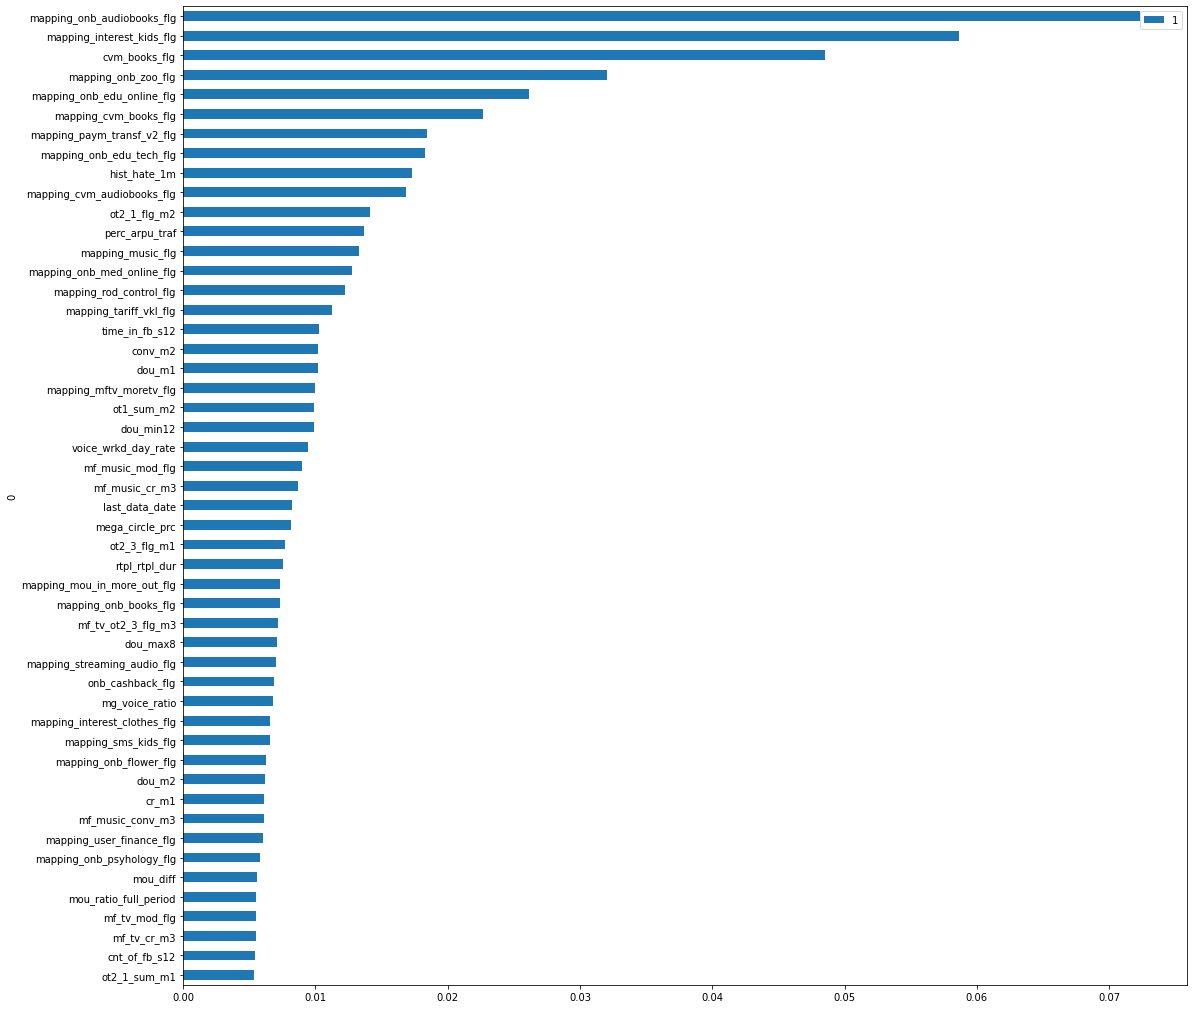

In [ ]:
mapper = {i: v for i, v in zip(data.columns, model.feature_importances_)}
n_feature = 50

feats_1 = pd.DataFrame(list(mapper.items())).sort_values([1],ascending=False)
feats_1.set_index([0])[:n_feature].sort_values([1],ascending=True).plot(figsize=(18, 18), kind='barh');


In [ ]:
import shap

/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [ ]:
shap.__version__

'0.39.0'

In [ ]:
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(model)

In [ ]:
shap_values = explainer.shap_values(X_test)

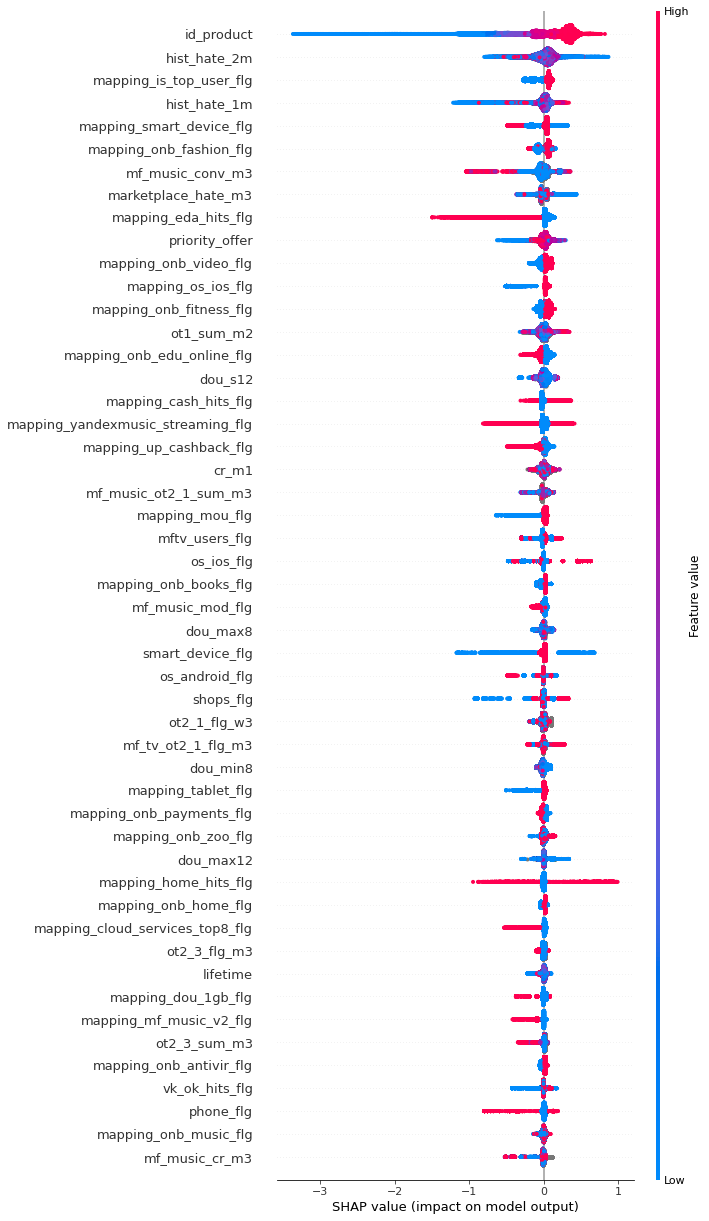

In [ ]:
shap.summary_plot(shap_values, max_display = 50, features = X_test , feature_names = X_test.columns)

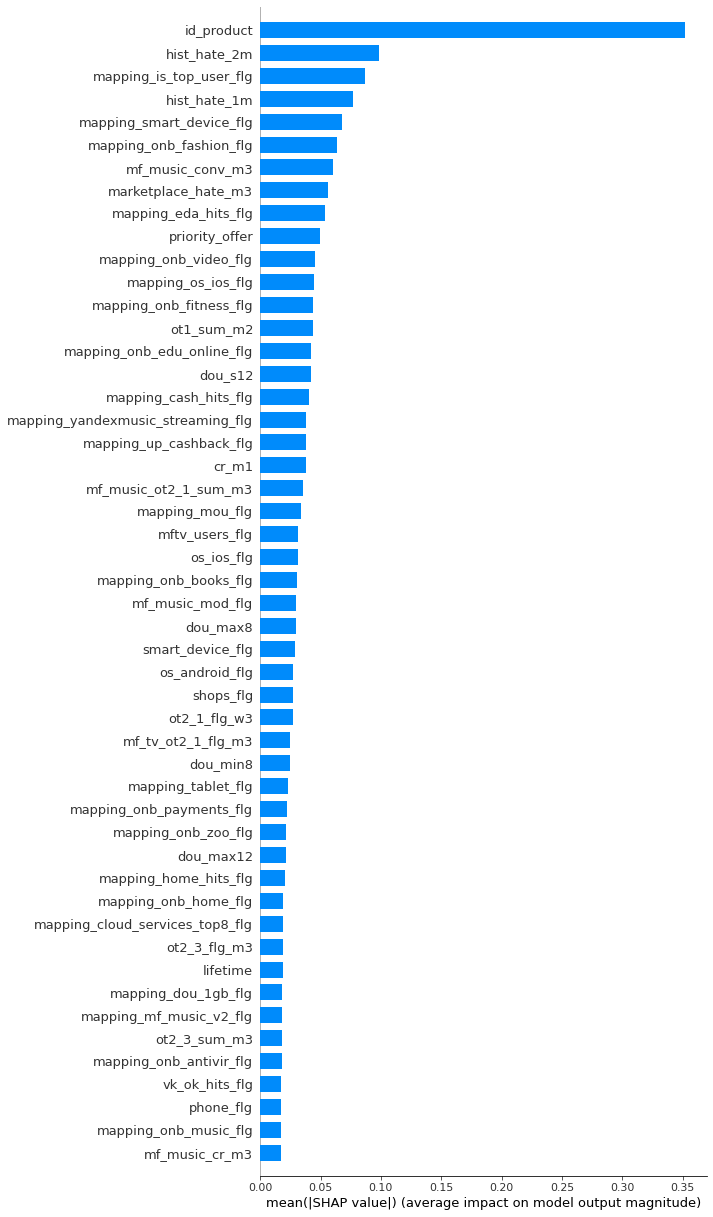

In [ ]:
shap.summary_plot(shap_values,max_display = 50, features = X_test, feature_names = X_test.columns, plot_type = 'bar')

In [ ]:
%%time
acc_at_3_list = []
acc_at_5_list = []
acc_at_10_list = []
of_density_1 = dict()
of_density_3 = dict()
of_density_5 = dict()
of_density_10 = dict()
score_table = pd.DataFrame(columns = ['user_id','id_offer','score'])
for (date, df_date), (date1, df_pos_date) in zip(data_test.groupby('start_date'),
                                               data_test_pos.groupby('start_date')):
    assert date1 == date
   
    print(pd.to_datetime(date, unit='s'))
    X_test_real_mapping = df_date[offer_vars_fin].drop_duplicates()
    #print(df_date)
    print(X_test_real_mapping.shape)
    
    user_df = df_pos_date.copy().loc[:,~df_pos_date.columns.isin(cat_features + ['id_offer'] + ['target'])]
    items_df = X_test_real_mapping.copy()    
    
    
    
    
    score_df =  xgboost_prediction(model,
                      user_df,
                      items_df,
                      all_features = prod_feat_acc[4:],
                      user_ids_column='sk_subs_id',
                      item_ids_column='id_offer')
    
    
    score_table = pd.concat([score_table, score_df])
    
    
    
    
    users_items_scores_prediction = score_df
    #print(score_df)
    users_items_real_interactions = df_pos_date[['sk_subs_id', 'id_offer']] 
   # print(users_items_real_interactions)
    
    _, of_density_1_temp = accuracy_at_k(users_items_scores_prediction, users_items_real_interactions, 
                             user_id_column_p = 'user_id', user_id_column_r = 'sk_subs_id', 
                             item_id_column_p = 'id_offer', item_id_column_r = 'id_offer',
                             score_column = 'score', k = 1)   
    acc_at_3, of_density_3_temp = accuracy_at_k(users_items_scores_prediction, users_items_real_interactions, 
                             user_id_column_p = 'user_id', user_id_column_r = 'sk_subs_id', 
                             item_id_column_p = 'id_offer', item_id_column_r = 'id_offer',
                             score_column = 'score', k = 3)    
    acc_at_3_list.append(acc_at_3)                                           
                                                
    acc_at_5, of_density_5_temp = accuracy_at_k(users_items_scores_prediction, users_items_real_interactions, 
                              user_id_column_p = 'user_id', user_id_column_r = 'sk_subs_id', 
                             item_id_column_p = 'id_offer', item_id_column_r = 'id_offer',
                             score_column = 'score', k = 5)    
    acc_at_5_list.append(acc_at_5)    
                                                
    acc_at_10, of_density_10_temp = accuracy_at_k(users_items_scores_prediction, users_items_real_interactions, 
                              user_id_column_p = 'user_id', user_id_column_r = 'sk_subs_id', 
                             item_id_column_p = 'id_offer', item_id_column_r = 'id_offer',
                             score_column = 'score', k = 10)    
    acc_at_10_list.append(acc_at_10) 
    #print((of_density_3_temp))
    of_density_1.update(of_density_1_temp)
    of_density_3.update(of_density_3_temp)
    of_density_5.update(of_density_5_temp)
    of_density_10.update(of_density_10_temp)
   #print(of_density_3)
   
print('ok')

2021-03-28 21:00:00
(38, 94)


KeyError: "['brnc_brnc_id' 'dvtp_dvtp_id' 'filial_id' 'hist_hate_1m' 'hist_hate_2m'\n 'priority_offer' 'region'] not in index"

In [ ]:
score_table.to_csv('score.csv')

In [ ]:
of_density_1 = {k: v for k, v in sorted(of_density_1.items(), key=lambda item: item[1])}

In [ ]:
of_density_1

Результаты метрики на тесте, после подбора гиперпараметров

In [ ]:
acc_at_3_list, acc_at_5_list, acc_at_10_list

([0.38481375358166187,
  0.2667666784327568,
  0.30475752700528613,
  0.3425716189207195],
 [0.5091690544412607,
  0.3257147899752912,
  0.3694552976327281,
  0.4105263157894737],
 [0.6126074498567335,
  0.3839569361101306,
  0.43219949436911054,
  0.5850766155896069])

Вытянем названия офферов 

In [ ]:
offer_name = pd.read_excel('/data/isbagaut/offer_name.xlsx',sep='delimiter')
#khd_tables/offer_name.csv

In [ ]:
of_density_3

In [ ]:
def offer_density_top1(of_density):
    density_1 = dict()
    for user in data_test_pos.sk_subs_id:
        #print(user)
        temp = int(list(of_density[user])[0])
    
        if temp in density_1 :
                density_1[temp] += 1
        else :
                density_1[temp] = 1
   
    density_1 = {k: v for k, v in sorted(density_1.items(), key=lambda item: item[1], reverse = True)}
    print(density_1)
    offer_list = []
    offer_list = [key for key in density_1]
    print(offer_list)
    num_for_offer = [value for value in density_1.values()]
    offer_list_head = [(offer_name[offer_name['PULL_OFFER_ID'] == i].PULL_OFFER_NAME).values for i in offer_list ]  
    offer_list_head = [i[0][:30] for i in offer_list_head]
    #fig, axes = plt.subplots(1,1,figsize = (15,5),sharey = True)
    plt.figure(figsize=(7, 10))
    plot = sns.barplot( x = num_for_offer , y =  offer_list_head)
    #plt.setp(plot.get_xticklabels(), rotation=90)
    
    #axes[0].set_title(offer_list_head) 
    count = 0 
    for i in offer_list_head :
        count +=1
        print(f'{count}',i)

Проведем анализ распределения офферов на каждом из топ 3 мест 

{1062990: 18113, 1063012: 10115, 1007659: 2524, 1063013: 1406, 1062979: 787, 1007673: 682, 1023788: 372, 1062998: 143, 1068899: 128, 1068897: 52, 1007675: 51, 1063005: 45, 1062996: 24, 1062997: 23, 1034318: 18, 1063009: 13, 1068898: 7, 1063010: 7, 1062993: 4, 1062980: 3, 1063004: 2}
[1062990, 1063012, 1007659, 1063013, 1062979, 1007673, 1023788, 1062998, 1068899, 1068897, 1007675, 1063005, 1062996, 1062997, 1034318, 1063009, 1068898, 1063010, 1062993, 1062980, 1063004]
1 МегаФон Пресса. Бесплатный Gla
2 МФ Музыка. 30 дн для всех серв
3 Выбирай любимые песни на гудки
4 МФ Музыка. BOOM 30 дней беспла
5 Автоплатеж. Скидка 10% на плат
6 Пакет "Большой Детский" на 14 
7 Промокод на бесплатный пробный
8 МегаФон ТВ. Кино по подп для р
9 МегаДиск. 100 ГБ бесплатно
10 МФ Здоровье. Скидка 80% в серв
11 Пакет "Максимальный" на 14 дне
12 Платежи и переводы. ЖКХ без ко
13 МегаФон ТВ. Cross для сериалов
14 МегаФон ТВ. Беспл фильм для ре
15 МегаФон Стоп-реклама. Бесплатн
16 МегаФон Банк. Кэшбэк до 30

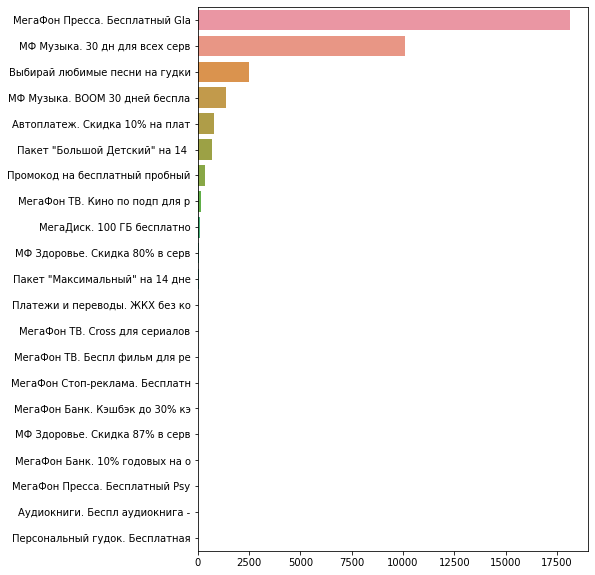

In [ ]:
offer_density_top1(of_density_1)

In [ ]:
def offer_density_top2(of_density):
    density_2 = dict()
    for user in data_test_pos.sk_subs_id:
        #print(user)
        temp = int(list(of_density[user])[1])
    
        if temp in density_2 :
                density_2[temp] += 1
        else :
                density_2[temp] = 1
    density_2 = {k: v for k, v in sorted(density_2.items(), key=lambda item: item[1], reverse = True)}
    print(density_1)
    offer_list = []
    offer_list = [key for key in density_2]
    print(offer_list)
    num_for_offer = [value for value in density_2.values()]
    offer_list_head = [(offer_name[offer_name['PULL_OFFER_ID'] == i].PULL_OFFER_NAME).values for i in offer_list ]  
    offer_list_head = [i[0][:30] for i in offer_list_head]
    plt.figure(figsize=(7, 10))
    plot = sns.barplot( x = num_for_offer , y =  offer_list_head)
    count = 0 
    for i in offer_list_head :
        count += 1
        print(f'{count}',i)

{1007673: 15859, 1062979: 854, 1007659: 4388, 1068899: 3595, 1068897: 927, 1063012: 5575, 1062994: 18, 1007675: 1653, 1062993: 347, 1068898: 168, 1023788: 347, 1023793: 108, 1062996: 17, 1062990: 64, 1062998: 70, 1063009: 75, 1063014: 103, 1062992: 50, 1034318: 132, 1063013: 140, 1062997: 11, 1062985: 1, 1063010: 13, 1062980: 2, 1063005: 2}
[1063012, 1063013, 1068899, 1007659, 1062990, 1023788, 1062979, 1007675, 1068898, 1062997, 1062996, 1007673, 1063005, 1063014, 1063010, 1007676, 1062998, 1063004, 1062980, 1062993, 1023793, 1068897, 1034318, 1062994]
1 МФ Музыка. 30 дн для всех серв
2 МФ Музыка. BOOM 30 дней беспла
3 МегаДиск. 100 ГБ бесплатно
4 Выбирай любимые песни на гудки
5 МегаФон Пресса. Бесплатный Gla
6 Промокод на бесплатный пробный
7 Автоплатеж. Скидка 10% на плат
8 Пакет "Максимальный" на 14 дне
9 МФ Здоровье. Скидка 87% в серв
10 МегаФон ТВ. Беспл фильм для ре
11 МегаФон ТВ. Cross для сериалов
12 Пакет "Большой Детский" на 14 
13 Платежи и переводы. ЖКХ без ко
14 МФ Музык

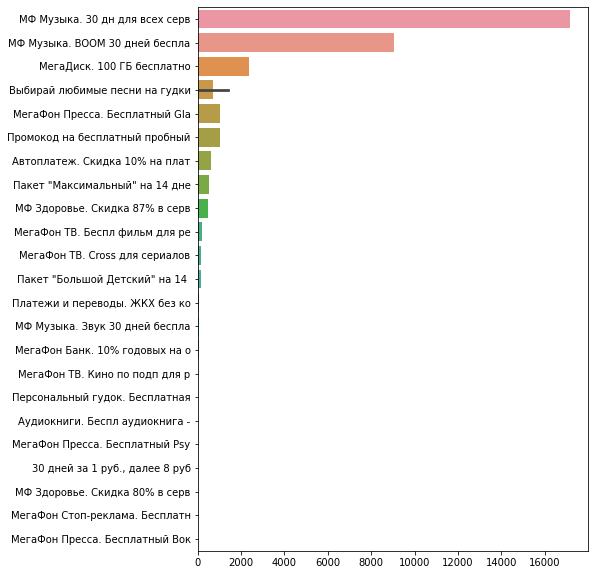

In [ ]:
offer_density_top2(of_density_3)

In [ ]:
def offer_density_top3(of_density):
    density_3 = dict()
    for user in data_test_pos.sk_subs_id:
        #print(user)
        temp = int(list(of_density[user])[0])
    
        if temp in density_3 :
                density_3[temp] += 1
        else :
                density_3[temp] = 1
    density_3 = {k: v for k, v in sorted(density_3.items(), key=lambda item: item[1], reverse = True)}
    print(density_1)
    offer_list = []
    offer_list = [key for key in density_3]
    print(offer_list)
    num_for_offer = [value for value in density_3.values()]
    offer_list_head = [(offer_name[offer_name['PULL_OFFER_ID'] == i].PULL_OFFER_NAME).values for i in offer_list ]  
    offer_list_head = [i[0][:30] for i in offer_list_head]
    plt.figure(figsize=(7, 10))
    plot = sns.barplot( x = num_for_offer , y =  offer_list_head)
    count = 0 
    for i in offer_list_head :
        count += 1
        print(f'{count}',i)

{1007673: 15859, 1062979: 854, 1007659: 4388, 1068899: 3595, 1068897: 927, 1063012: 5575, 1062994: 18, 1007675: 1653, 1062993: 347, 1068898: 168, 1023788: 347, 1023793: 108, 1062996: 17, 1062990: 64, 1062998: 70, 1063009: 75, 1063014: 103, 1062992: 50, 1034318: 132, 1063013: 140, 1062997: 11, 1062985: 1, 1063010: 13, 1062980: 2, 1063005: 2}
[1007673, 1063012, 1007659, 1068899, 1007675, 1068897, 1062979, 1062993, 1023788, 1068898, 1063013, 1034318, 1023793, 1063014, 1063009, 1062998, 1062990, 1062992, 1062994, 1062996, 1063010, 1062997, 1062980, 1063005, 1062985]
1 Пакет "Большой Детский" на 14 
2 МФ Музыка. 30 дн для всех серв
3 Выбирай любимые песни на гудки
4 МегаДиск. 100 ГБ бесплатно
5 Пакет "Максимальный" на 14 дне
6 МФ Здоровье. Скидка 80% в серв
7 Автоплатеж. Скидка 10% на плат
8 МегаФон Пресса. Бесплатный Psy
9 Промокод на бесплатный пробный
10 МФ Здоровье. Скидка 87% в серв
11 МФ Музыка. BOOM 30 дней беспла
12 МегаФон Стоп-реклама. Бесплатн
13 30 дней за 1 руб., далее 8 руб
14

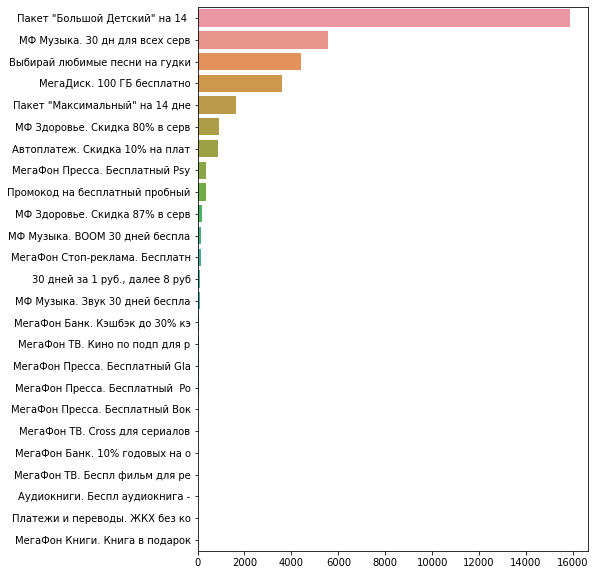

In [ ]:
offer_density_top3(of_density_3)

In [ ]:
    density_1 = dict()
    for user in data_test_pos.sk_subs_id:
        #print(user)
        temp = int(list(of_density_3[user])[0])
    
        if temp in density_1 :
                density_1[temp] += 1
        else :
                density_1[temp] = 1

In [ ]:
density_1

{1007673: 15859,
 1062979: 854,
 1007659: 4388,
 1068899: 3595,
 1068897: 927,
 1063012: 5575,
 1062994: 18,
 1007675: 1653,
 1062993: 347,
 1068898: 168,
 1023788: 347,
 1023793: 108,
 1062996: 17,
 1062990: 64,
 1062998: 70,
 1063009: 75,
 1063014: 103,
 1062992: 50,
 1034318: 132,
 1063013: 140,
 1062997: 11,
 1062985: 1,
 1063010: 13,
 1062980: 2,
 1063005: 2}

распределение частоты офферов, которые предсказываются в топ К

In [ ]:
def offer_distribution(of_density):
    density = dict()
    for user in data_test_pos.sk_subs_id:
        #print(user)
        temp = list(of_density[user])
       # print(temp[0])
        for k in range(len(temp)) :
           
            if temp[k] in density :
                density[temp[k]] += 1
            else :
                density[temp[k]] = 1
    density = {k: v for k, v in sorted(density.items(), key=lambda item: item[1], reverse = True)}
    print(density_1)
    offer_list = []
    offer_list = [key for key in density]
    print(offer_list)
    num_for_offer = [value for value in density.values()]
    offer_list_head = [(offer_name[offer_name['PULL_OFFER_ID'] == i].PULL_OFFER_NAME).values for i in offer_list ]  
    #print(offer_list_head)
    offer_list_head = [i[0][:30] for i in offer_list_head]
    plt.figure(figsize=(7, 10))
    plot = sns.barplot( x = num_for_offer , y =  offer_list_head)
    count = 0 
    for i in offer_list_head :
        count +=1
        print(f'{count}',i)

{1007673: 15859, 1062979: 854, 1007659: 4388, 1068899: 3595, 1068897: 927, 1063012: 5575, 1062994: 18, 1007675: 1653, 1062993: 347, 1068898: 168, 1023788: 347, 1023793: 108, 1062996: 17, 1062990: 64, 1062998: 70, 1063009: 75, 1063014: 103, 1062992: 50, 1034318: 132, 1063013: 140, 1062997: 11, 1062985: 1, 1063010: 13, 1062980: 2, 1063005: 2}
[1062990.0, 1063012.0, 1007659.0, 1063013.0, 1062979.0, 1007673.0, 1023788.0, 1062998.0, 1068899.0, 1068897.0, 1007675.0, 1063005.0, 1062996.0, 1062997.0, 1034318.0, 1063009.0, 1068898.0, 1063010.0, 1062993.0, 1062980.0, 1063004.0]
1 МегаФон Пресса. Бесплатный Gla
2 МФ Музыка. 30 дн для всех серв
3 Выбирай любимые песни на гудки
4 МФ Музыка. BOOM 30 дней беспла
5 Автоплатеж. Скидка 10% на плат
6 Пакет "Большой Детский" на 14 
7 Промокод на бесплатный пробный
8 МегаФон ТВ. Кино по подп для р
9 МегаДиск. 100 ГБ бесплатно
10 МФ Здоровье. Скидка 80% в серв
11 Пакет "Максимальный" на 14 дне
12 Платежи и переводы. ЖКХ без ко
13 МегаФон ТВ. Cross для сериа

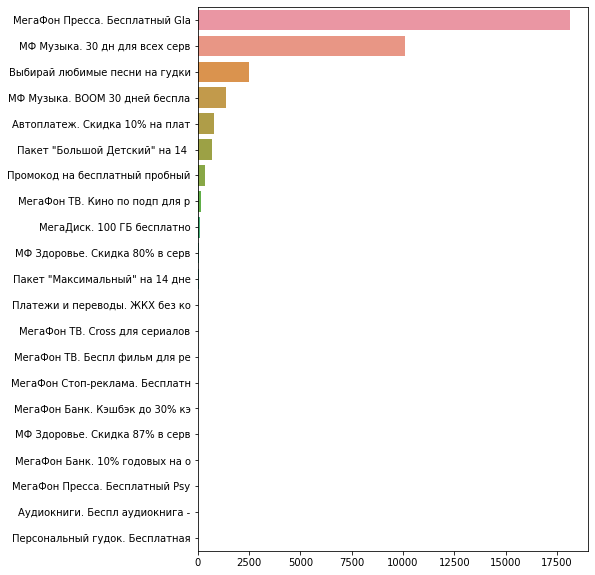

In [ ]:
offer_distribution(of_density_1)

{1007673: 15859, 1062979: 854, 1007659: 4388, 1068899: 3595, 1068897: 927, 1063012: 5575, 1062994: 18, 1007675: 1653, 1062993: 347, 1068898: 168, 1023788: 347, 1023793: 108, 1062996: 17, 1062990: 64, 1062998: 70, 1063009: 75, 1063014: 103, 1062992: 50, 1034318: 132, 1063013: 140, 1062997: 11, 1062985: 1, 1063010: 13, 1062980: 2, 1063005: 2}
[1062990.0, 1063012.0, 1007673.0, 1063013.0, 1068899.0, 1007659.0, 1023788.0, 1007675.0, 1062979.0, 1068897.0, 1063005.0, 1068898.0, 1062998.0, 1034318.0, 1062993.0, 1063014.0, 1062997.0, 1062996.0, 1063015.0, 1023793.0, 1007676.0, 1063010.0, 1063009.0, 1062992.0, 1063004.0, 1062980.0, 1062994.0, 1062991.0, 1062985.0]
1 МегаФон Пресса. Бесплатный Gla
2 МФ Музыка. 30 дн для всех серв
3 Пакет "Большой Детский" на 14 
4 МФ Музыка. BOOM 30 дней беспла
5 МегаДиск. 100 ГБ бесплатно
6 Выбирай любимые песни на гудки
7 Промокод на бесплатный пробный
8 Пакет "Максимальный" на 14 дне
9 Автоплатеж. Скидка 10% на плат
10 МФ Здоровье. Скидка 80% в серв
11 Платежи

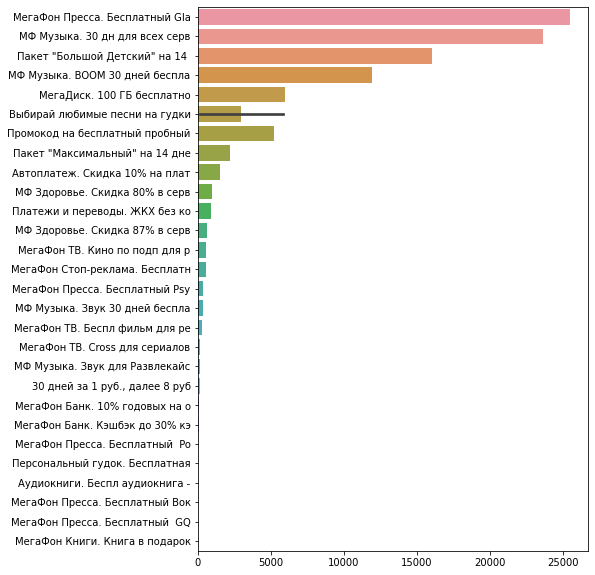

In [ ]:
offer_distribution(of_density_3)

{1007673: 15859, 1062979: 854, 1007659: 4388, 1068899: 3595, 1068897: 927, 1063012: 5575, 1062994: 18, 1007675: 1653, 1062993: 347, 1068898: 168, 1023788: 347, 1023793: 108, 1062996: 17, 1062990: 64, 1062998: 70, 1063009: 75, 1063014: 103, 1062992: 50, 1034318: 132, 1063013: 140, 1062997: 11, 1062985: 1, 1063010: 13, 1062980: 2, 1063005: 2}
[1062990.0, 1063012.0, 1063013.0, 1007673.0, 1068899.0, 1023788.0, 1007675.0, 1007659.0, 1068897.0, 1068898.0, 1062993.0, 1063014.0, 1062979.0, 1034318.0, 1063005.0, 1062997.0, 1062998.0, 1063015.0, 1023793.0, 1062992.0, 1062994.0, 1007676.0, 1063004.0, 1062996.0, 1063010.0, 1063009.0, 1062980.0, 1062991.0, 1062985.0, 1063018.0, 1062995.0, 1063000.0, 1063007.0, 1034319.0]
1 МегаФон Пресса. Бесплатный Gla
2 МФ Музыка. 30 дн для всех серв
3 МФ Музыка. BOOM 30 дней беспла
4 Пакет "Большой Детский" на 14 
5 МегаДиск. 100 ГБ бесплатно
6 Промокод на бесплатный пробный
7 Пакет "Максимальный" на 14 дне
8 Выбирай любимые песни на гудки
9 МФ Здоровье. Скидка 

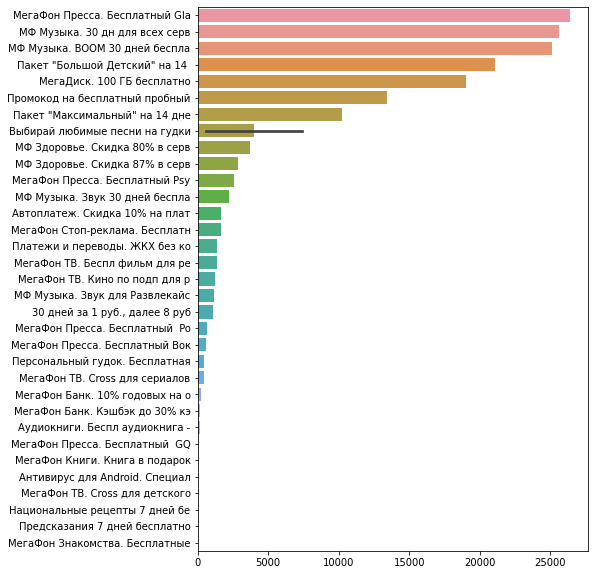

In [ ]:
offer_distribution(of_density_5)

{1007673: 15859, 1062979: 854, 1007659: 4388, 1068899: 3595, 1068897: 927, 1063012: 5575, 1062994: 18, 1007675: 1653, 1062993: 347, 1068898: 168, 1023788: 347, 1023793: 108, 1062996: 17, 1062990: 64, 1062998: 70, 1063009: 75, 1063014: 103, 1062992: 50, 1034318: 132, 1063013: 140, 1062997: 11, 1062985: 1, 1063010: 13, 1062980: 2, 1063005: 2}
[1068899.0, 1063013.0, 1062990.0, 1063012.0, 1007673.0, 1007675.0, 1023788.0, 1068897.0, 1068898.0, 1063014.0, 1062993.0, 1007659.0, 1063015.0, 1023793.0, 1062994.0, 1034318.0, 1062997.0, 1062992.0, 1062998.0, 1063005.0, 1062979.0, 1007676.0, 1063004.0, 1063009.0, 1063010.0, 1062996.0, 1062991.0, 1062985.0, 1062980.0, 1034319.0, 1062995.0, 1063018.0, 1063001.0, 1063000.0, 1063019.0, 1062981.0, 1063007.0]
1 МегаДиск. 100 ГБ бесплатно
2 МФ Музыка. BOOM 30 дней беспла
3 МегаФон Пресса. Бесплатный Gla
4 МФ Музыка. 30 дн для всех серв
5 Пакет "Большой Детский" на 14 
6 Пакет "Максимальный" на 14 дне
7 Промокод на бесплатный пробный
8 МФ Здоровье. Скидка 

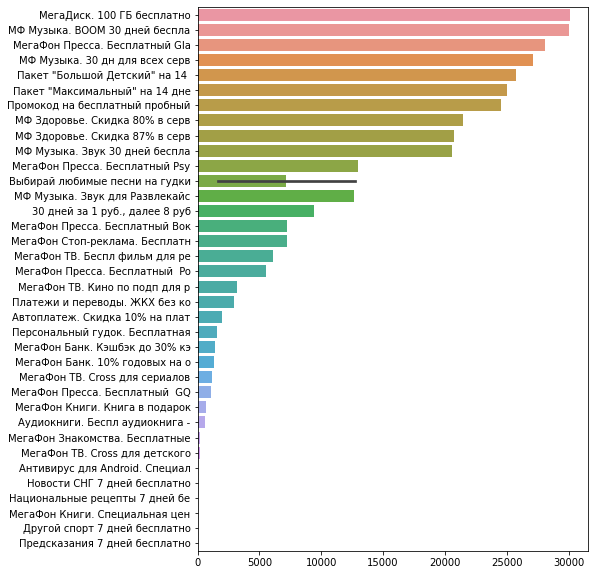

In [ ]:
offer_distribution(of_density_10)

In [ ]:
conv = pd.read_excel('/home/isbagaut/khd_tables/conv.xlsx')

In [ ]:
conv.head()

,Названия строк,Сумма по полю OT_1,Сумма по полю OT_2_3,Средняя конверсия
0,DCB_GooglePay,3,0,0.0000
1,Автоответчик для iPhone со скидкой 50%,498,0,0.0000
2,Автоплатеж. Скидка 10% на плату за тариф,66167,1537,0.0232
3,Антивирус для Android. Специальная цена 55 руб...,12968,33,0.0025
4,Аудиокниги. 7 дней бесплатно,278,1,0.0036


In [ ]:
conv['Названия строк']

0                                         DCB_GooglePay
1                Автоответчик для iPhone со скидкой 50%
2              Автоплатеж. Скидка 10% на плату за тариф
3     Антивирус для Android. Специальная цена 55 руб...
4                          Аудиокниги. 7 дней бесплатно
5                Аудиокниги. Беспл аудиокнига - Пелевин
6                      Замени гудок. Бесплатная мелодия
7                            МегаДиск. 100 ГБ бесплатно
8       МегаФон Книги. Книга в подарок - Комиссар Мегре
9     МегаФон Книги. Специальная цена 14 дней бесплатно
10    МегаФон Пресса. 30 дней за 1 руб., далее 12 ру...
11                       МегаФон Пресса. Бесплатный  GQ
12                 МегаФон Пресса. Бесплатный  Pop mech
13                   МегаФон Пресса. Бесплатный Glamour
14              МегаФон Пресса. Бесплатный Psychologies
15              МегаФон Пресса. Бесплатный Вокруг света
16           МегаФон Стоп-реклама. Бесплатно на 30 дней
17                 МегаФон ТВ. Cross для детског

In [ ]:
def offer_distribution_conv(of_density):
    density = dict()
    for user in data_test_pos.sk_subs_id:
        #print(user)
        temp = list(of_density[user])
       # print(temp[0])
        for k in range(len(temp)) :
           
            if temp[k] in density :
                density[temp[k]] += 1
            else :
                density[temp[k]] = 1
    density = {k: v for k, v in sorted(density.items(), key=lambda item: item[1], reverse = True)}
   # print(density_1)
    offer_list = []
    offer_list = [key for key in density]
    #print(offer_list)
    num_for_offer = [value for value in density.values()]
    offer_list_head = [(offer_name[offer_name['PULL_OFFER_ID'] == i].PULL_OFFER_NAME).values for i in offer_list ]  
    
    offer_list_head = [i[0] for i in offer_list_head]
    offer_list_head_2 = [i[:30] for i in offer_list_head]
    #print(offer_list_head)
    #offer_list_head = [(i,conv[conv['Названия строк'] == i]['Средняя конверсия']) for i in offer_list_head if  not conv[conv['Названия строк'] == i].empty else: (i,0) ]
    offer_list_temp = []
    for i in offer_list_head :
        if  conv[conv['Названия строк'] == i].empty:
            
            offer_list_temp.append((i,0))
           # print(i,'Empty')
            
        else: 
            offer_list_temp.append((i,conv[conv['Названия строк'] == i]['Средняя конверсия'].values[0]))
    #print(offer_list_temp)
    print(offer_list_head_2)
    sns.set(rc = {'figure.figsize':(15,8)})
    sns.barplot(x = [i[1] for i in offer_list_temp],y = offer_list_head_2 );
    conver = 0 
    print(sum(num_for_offer))
    for i,n in zip(offer_list_temp,num_for_offer):
        conver += i[1] * n
    print(conver)
   

['МегаФон Пресса. Бесплатный Gla', 'МФ Музыка. 30 дн для всех серв', 'Пакет "Большой Детский" на 14 ', 'МФ Музыка. BOOM 30 дней беспла', 'МегаДиск. 100 ГБ бесплатно', 'Выбирай любимые песни на гудки', 'Промокод на бесплатный пробный', 'Пакет "Максимальный" на 14 дне', 'Автоплатеж. Скидка 10% на плат', 'МФ Здоровье. Скидка 80% в серв', 'Платежи и переводы. ЖКХ без ко', 'МФ Здоровье. Скидка 87% в серв', 'МегаФон ТВ. Кино по подп для р', 'МегаФон Стоп-реклама. Бесплатн', 'МегаФон Пресса. Бесплатный Psy', 'МФ Музыка. Звук 30 дней беспла', 'МегаФон ТВ. Беспл фильм для ре', 'МегаФон ТВ. Cross для сериалов', 'МФ Музыка. Звук для Развлекайс', '30 дней за 1 руб., далее 8 руб', 'Выбирай любимые песни на гудки', 'МегаФон Банк. 10% годовых на о', 'МегаФон Банк. Кэшбэк до 30% кэ', 'МегаФон Пресса. Бесплатный  Po', 'Персональный гудок. Бесплатная', 'Аудиокниги. Беспл аудиокнига -', 'МегаФон Пресса. Бесплатный Вок', 'МегаФон Пресса. Бесплатный  GQ', 'МегаФон Книги. Книга в подарок']
103557
5086.1455


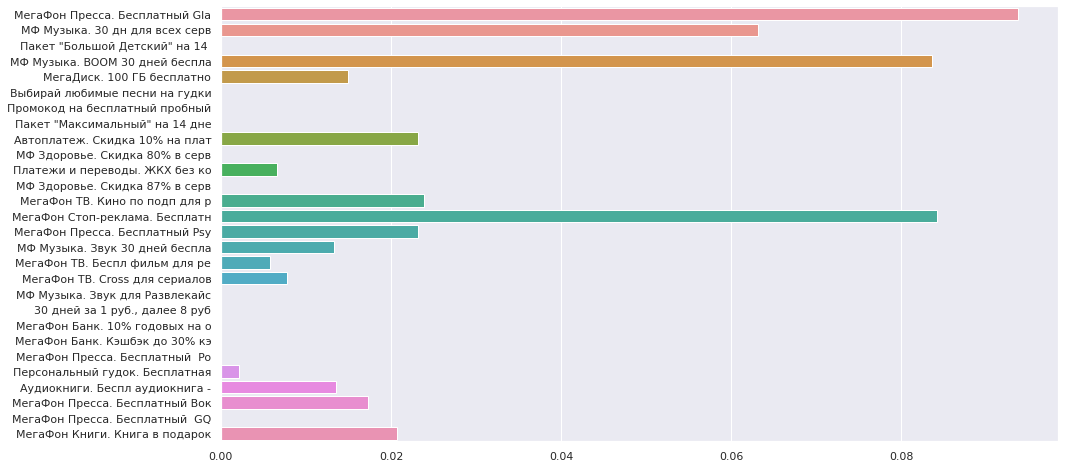

In [ ]:
offer_distribution_conv(of_density_3)

In [ ]:
import pickle

In [ ]:
enc_name = 'Catboost_encoder,pkl'
pickle.dump(cbe_encoder, open(enc_name, 'wb'))

In [ ]:
filename = 'xgb_pairwise.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
